In [ ]:
# !pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org -U kaleido

# Metrolinx Rideship Regression Analysis

In [1]:
# Importing all necessary libraries to proceed with this project.
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import random
import sqlite3
import itertools
from itertools import cycle, islice
from datetime import timedelta

import plotly.express as px
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression, LassoCV, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.pipeline import make_pipeline

import os
ss = StandardScaler()

In [2]:
import utils
from utils import adjustedR2

In [3]:
os.getcwd()

'C:\\Users\\DKici\\Desktop\\Metrolinx\\notebook'

#### Load and read data

In [10]:
input_path = f"{os.getcwd()}\\input_data\\"
ts_path = f"{os.getcwd()}\\ts_data\\"
output_path = "C:\\Users\\DKici\\Desktop\\Metrolinx\\"
figures_path = f"{output_path}\\figures\\"

In [11]:
figures_path

'C:\\Users\\DKici\\Desktop\\Metrolinx\\\\figures\\'

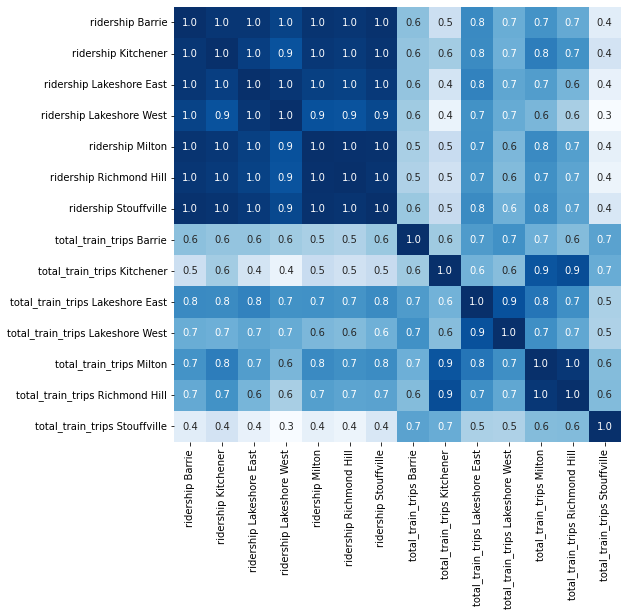

In [5]:
rc_df = pd.read_csv(f"{ts_path}\\Rail_Corridor_Data.csv")
rc_df = rc_df.fillna(0)
plt.figure(figsize = (8,8))
ax = sns.heatmap(rc_df.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

Barrie
Kitchener
Lakeshore East
Lakeshore West
Milton
Richmond Hill
Stouffville


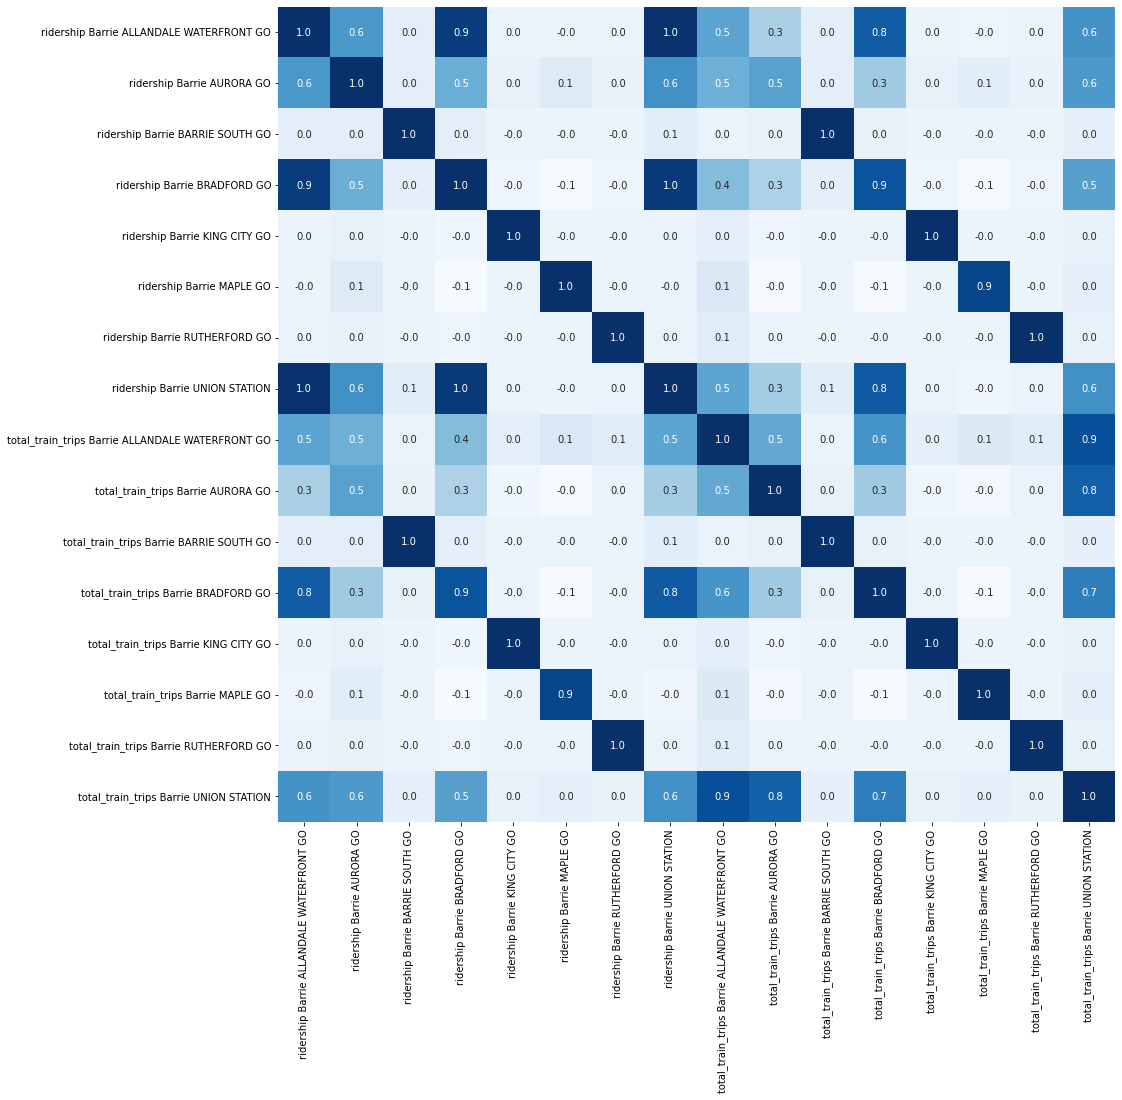

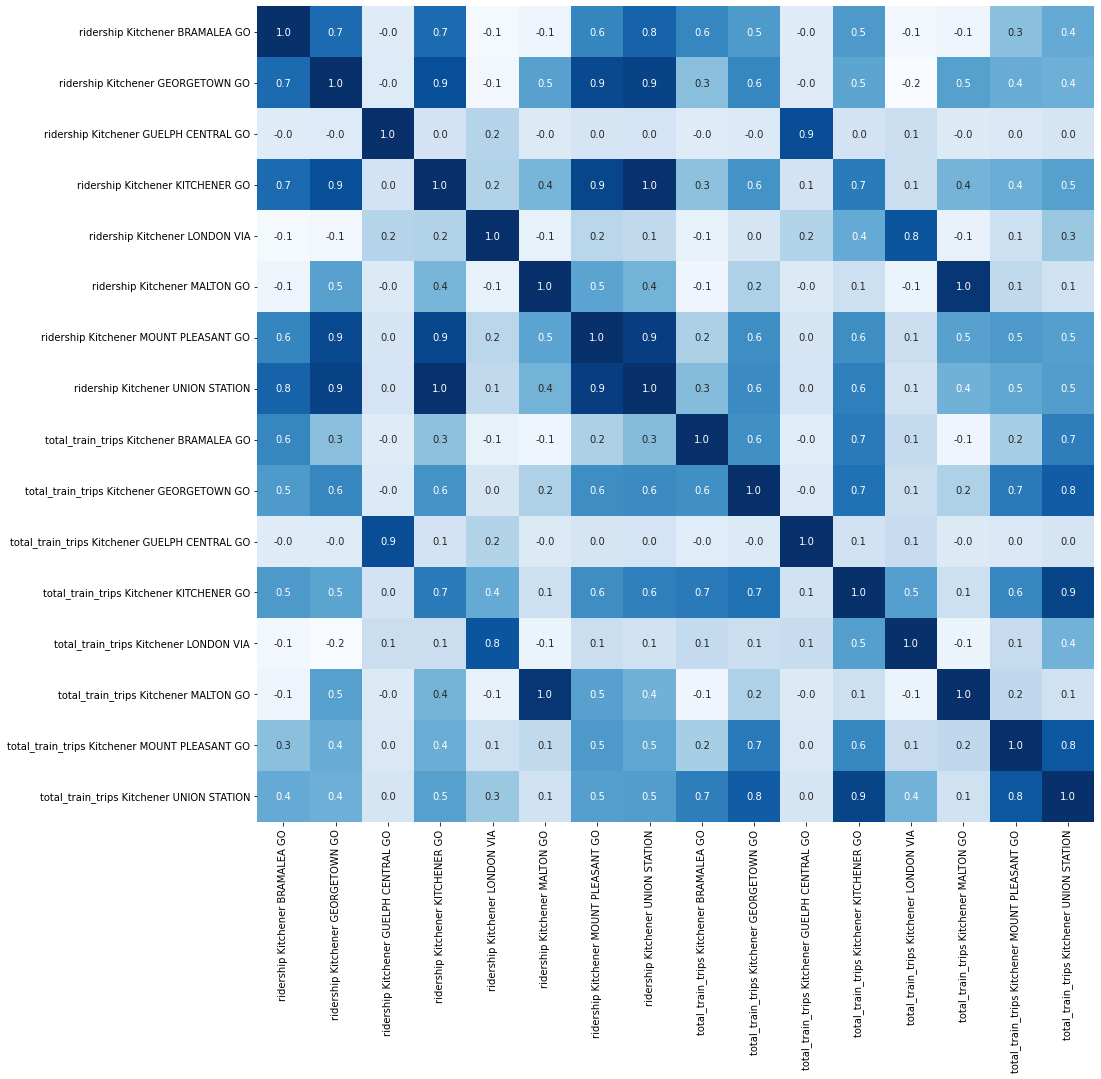

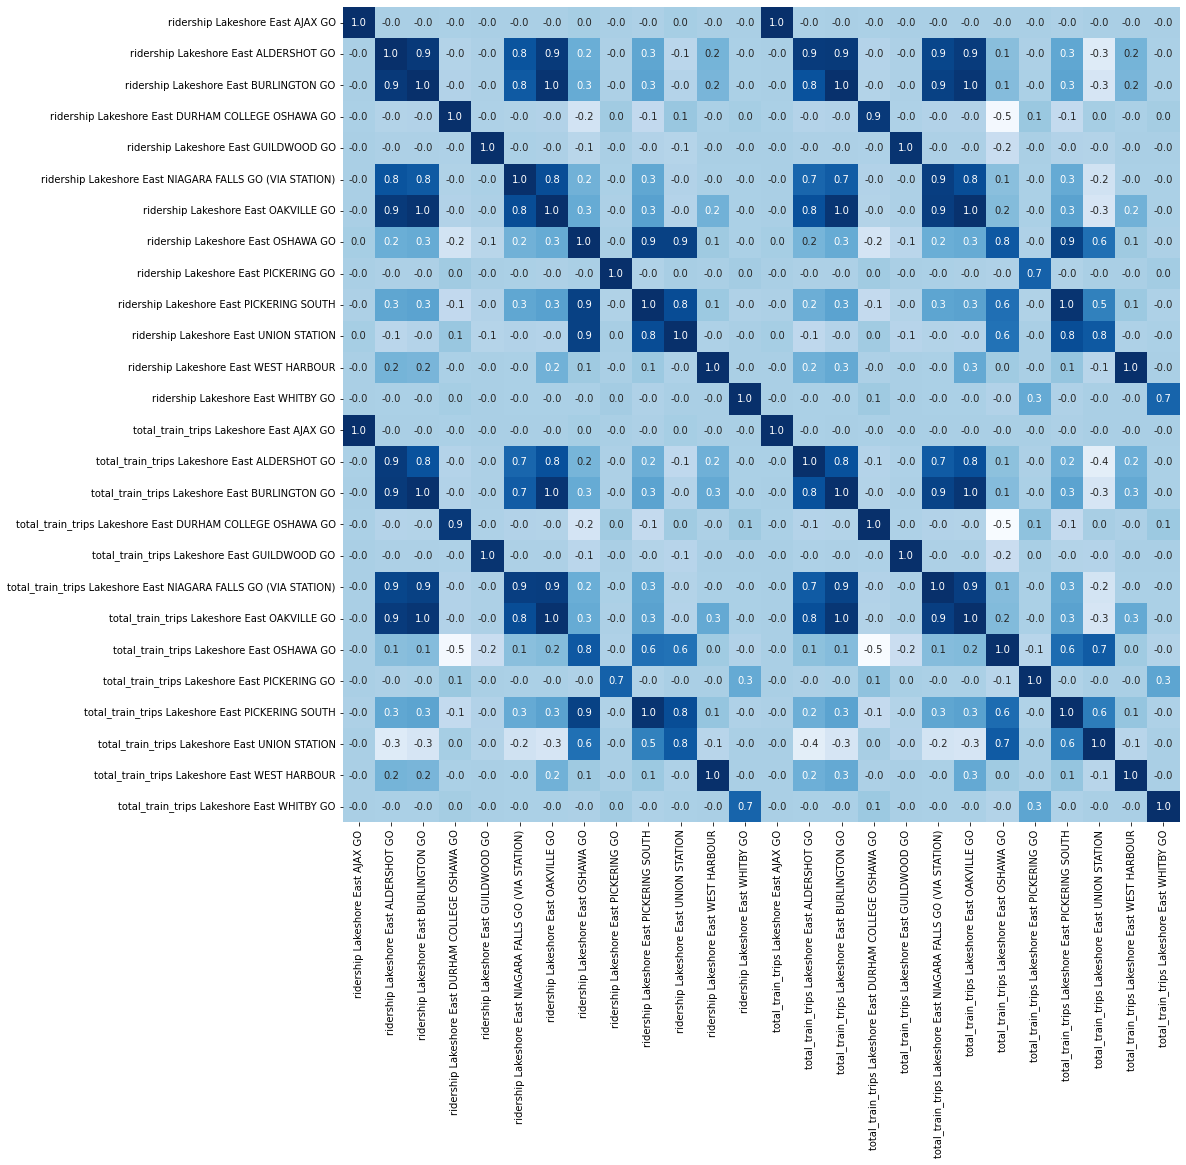

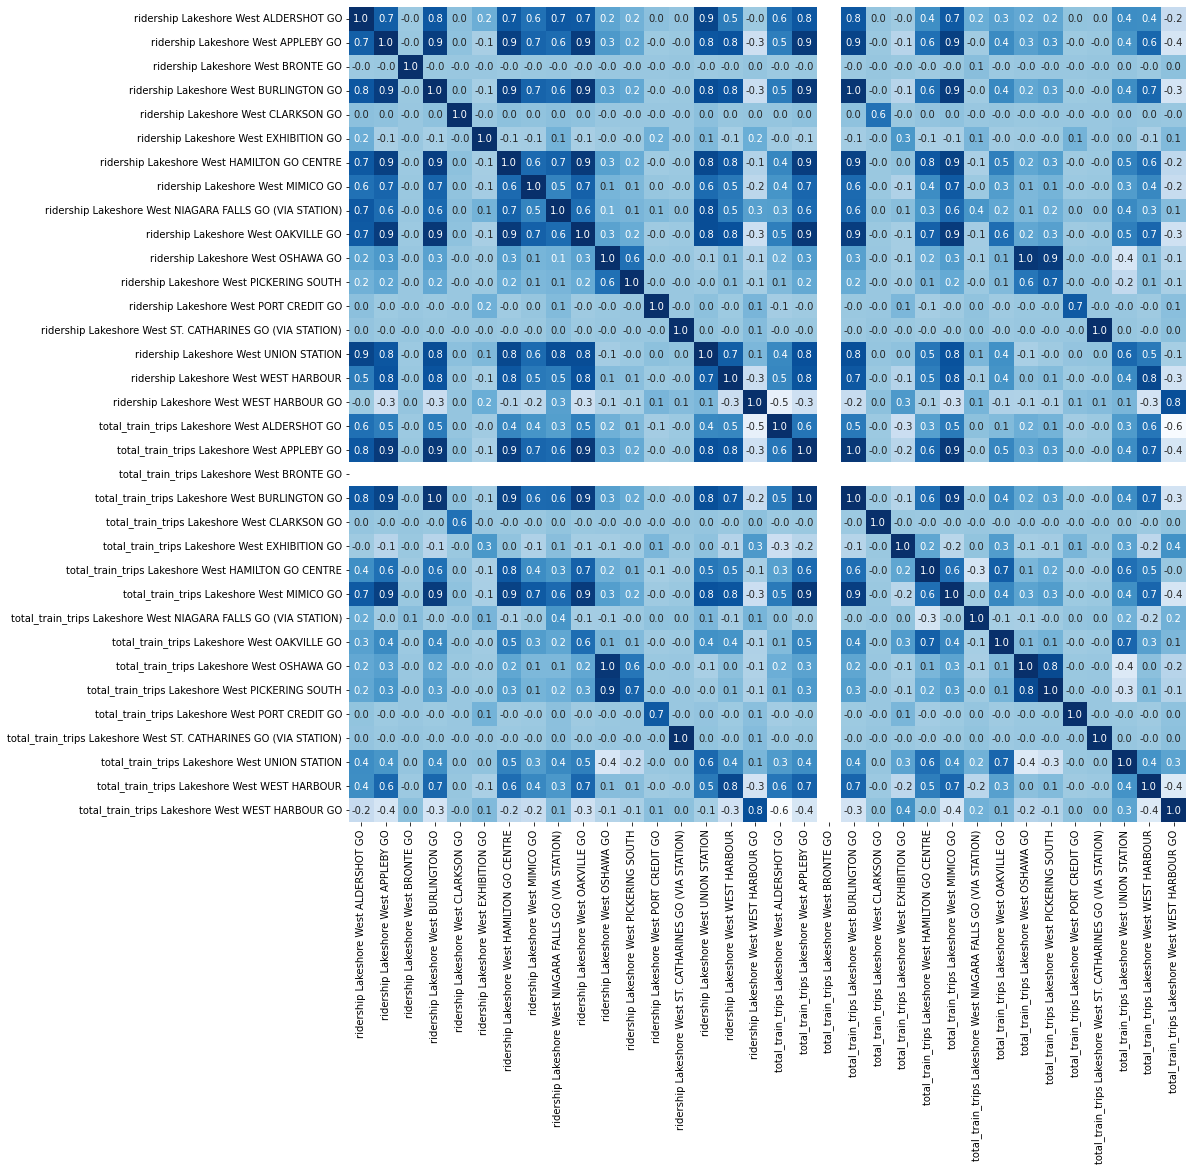

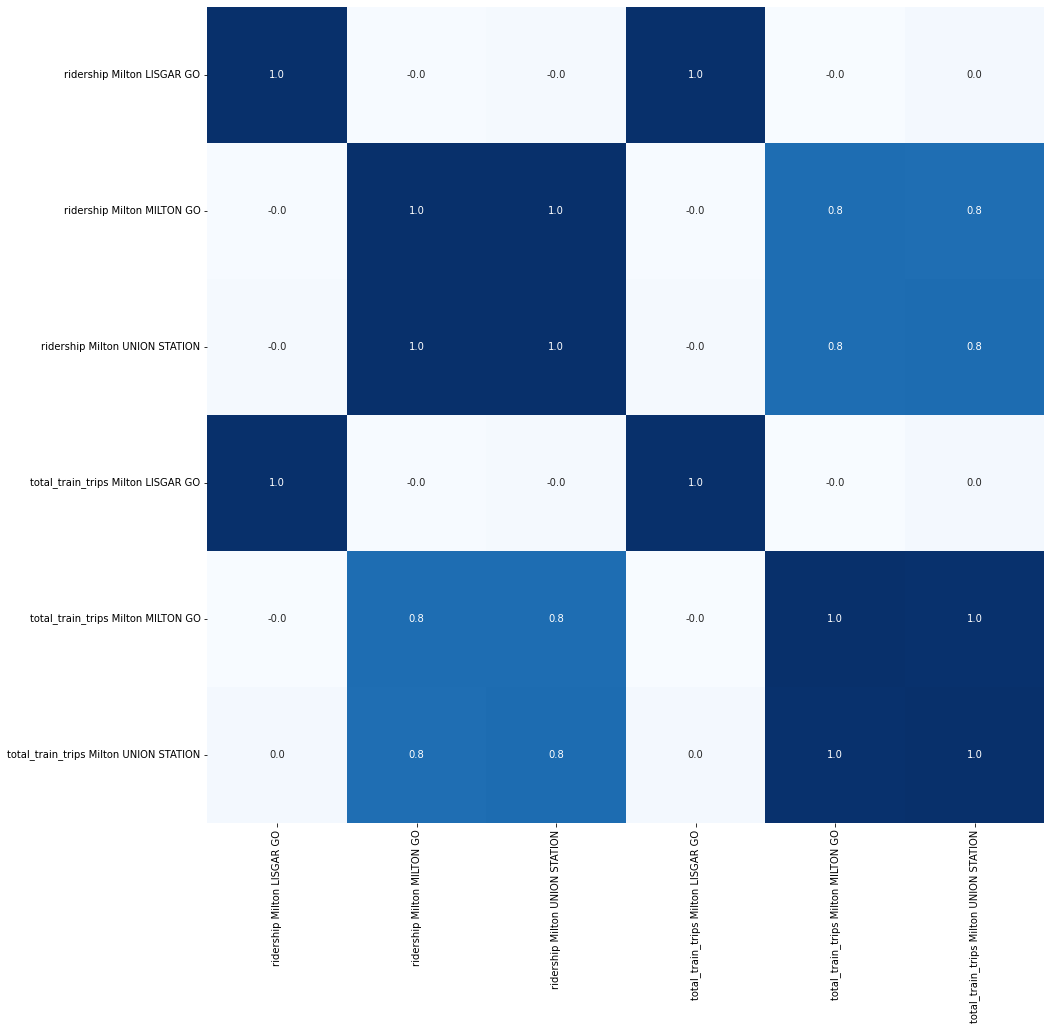

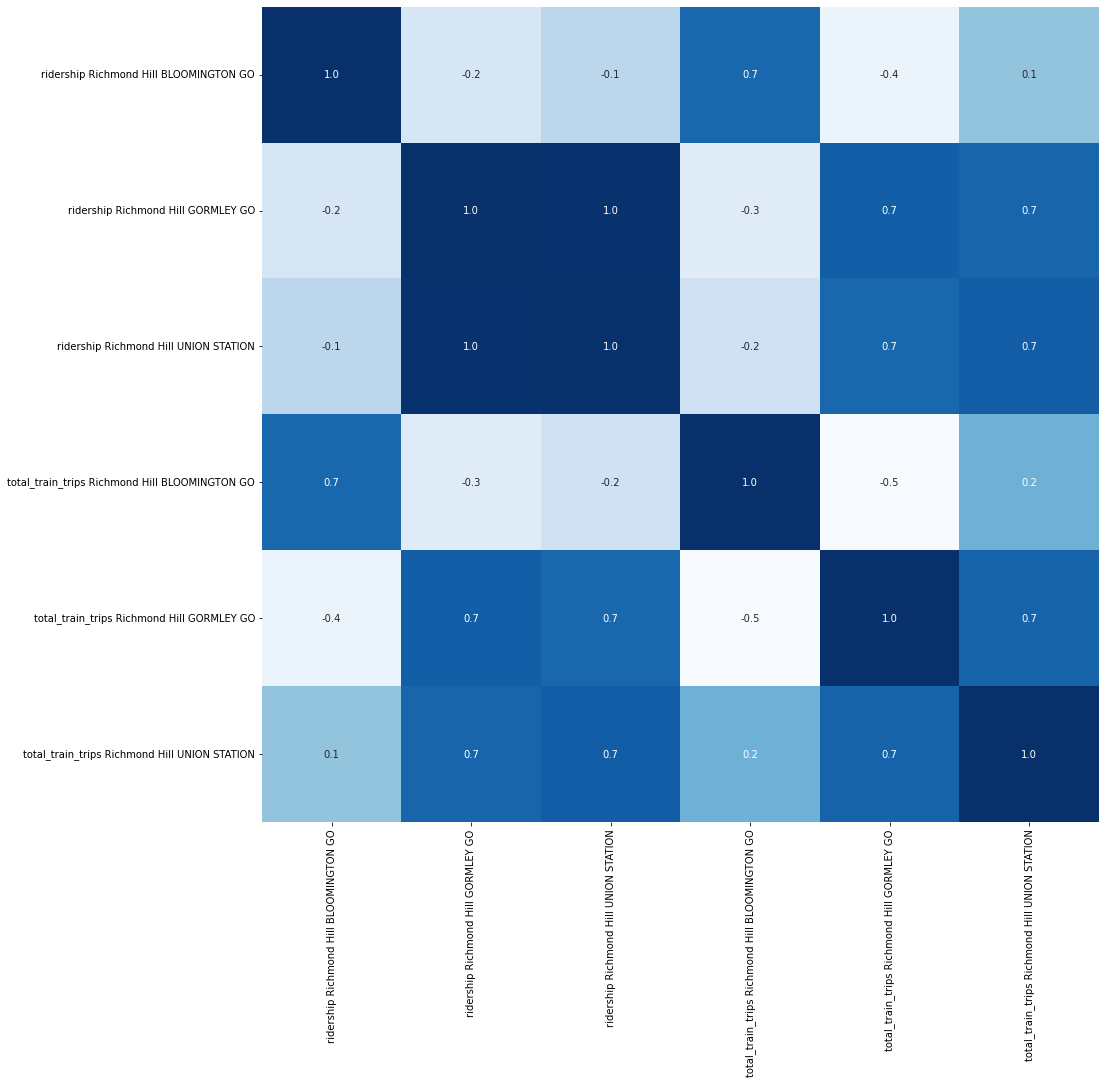

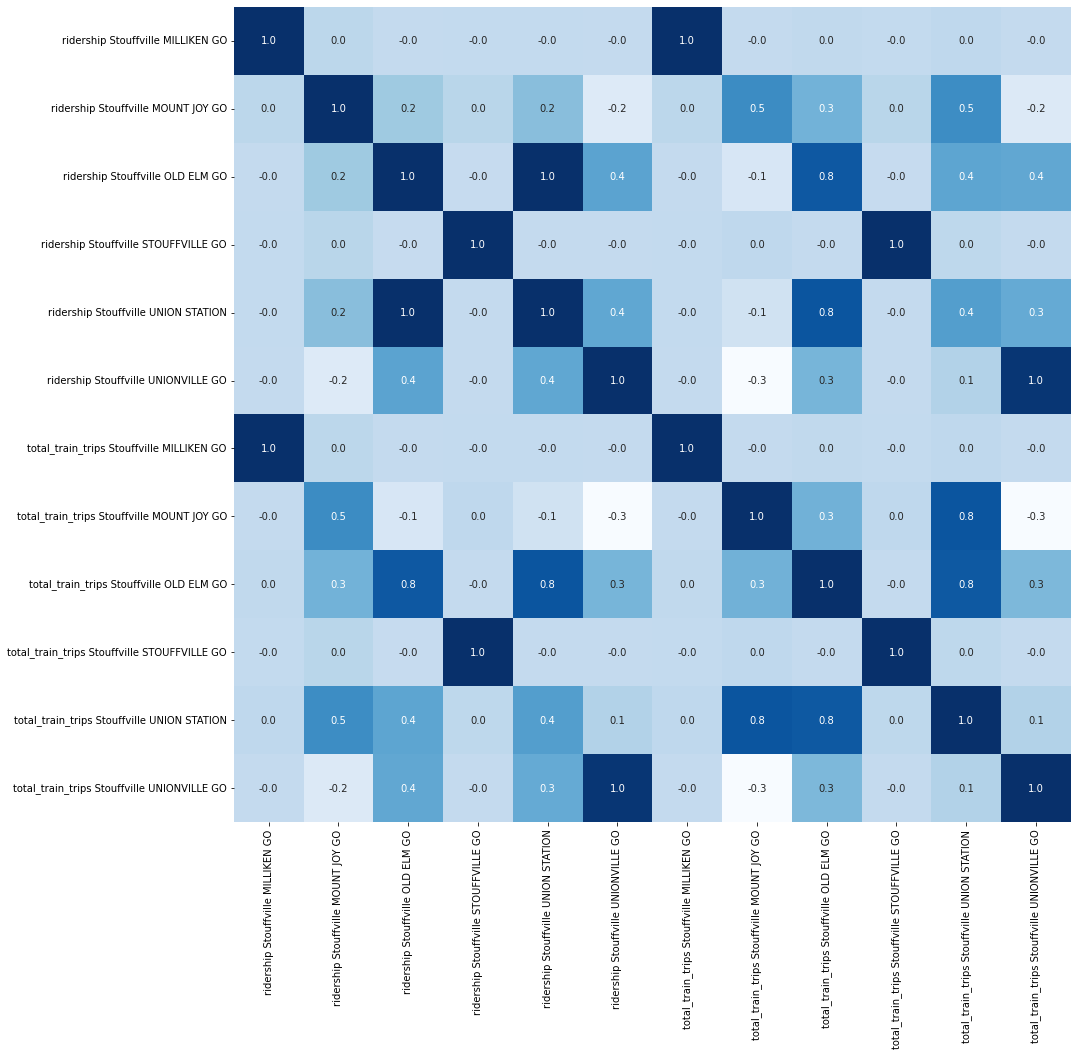

In [12]:
st_df = pd.read_csv(f"{ts_path}\\Station_Data.csv")
st_df = st_df.fillna(0)

stations = ['Barrie','Kitchener','Lakeshore East','Lakeshore West', 'Milton', 'Richmond Hill', 'Stouffville']

for st in stations:
    print(st)
    st_temp =  st_df.columns[st_df.columns.str.contains(pat = f'{st}')] 

    plt.figure(figsize = (15,15))
    ax = sns.heatmap(st_df[st_temp].corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')
    plt.savefig(f'{figures_path}/{st}_stations_correlations.png')

In [15]:
rc_df["date"]=pd.to_datetime(rc_df.date)
rc_df["Week"]=rc_df.date.dt.week
rc_df["Month"]=rc_df.date.dt.month
rc_df["Year"]=rc_df.date.dt.year
# Changing the Months value from numbers to real values like Jan, Feb to Dec
# rc_df['Month'] = rc_df['Month'].apply(lambda x: calendar.month_abbr[x])

In [16]:
rc_df.describe().T

count          mean           std     min  \
ridership Barrie                  1461.0   4400.605065   5347.616399     0.0   
ridership Kitchener               1461.0   4856.924709   6199.820190     0.0   
ridership Lakeshore East          1461.0  12375.724162  11884.308002     0.0   
ridership Lakeshore West          1461.0  16216.637919  15623.745199     0.0   
ridership Milton                  1461.0   4897.070500   7363.907604     0.0   
ridership Richmond Hill           1461.0   1880.291581   3009.700675     0.0   
ridership Stouffville             1461.0   3457.464750   4609.707402     0.0   
total_train_trips Barrie          1461.0     25.484600     10.512123     0.0   
total_train_trips Kitchener       1461.0     23.981520     17.237235     0.0   
total_train_trips Lakeshore East  1461.0     80.175222     31.562974     0.0   
total_train_trips Lakeshore West  1461.0     78.433265     27.903733     0.0   
total_train_trips Milton          1461.0      9.458590      7.610859     0.0   
total_train_trips Richmond Hill   1461.0      6.167009      4.613207     0.0   
total_train_trips Stouffville     1461.0     23.829569     11.906098     0.0   
Week                              1461.0     26.626968     15.069603     1.0   
Month                             1461.0      6.522930      3.449884     1.0   
Year                              1461.0   2020.499658      1.118111  2019.0   

                                     25%     50%      75%      max  
ridership Barrie                   757.0  1813.0   5768.0  19119.0  
ridership Kitchener                  0.0  1647.0   7615.0  23991.0  
ridership Lakeshore East          3421.0  7422.0  17304.0  50318.0  
ridership Lakeshore West          3679.0  9839.0  25178.0  71920.0  
ridership Milton                     0.0   946.0   5430.0  24170.0  
ridership Richmond Hill              0.0   244.0   1807.0   8978.0  
ridership Stouffville              295.0   928.0   4520.0  17103.0  
total_train_trips Barrie            21.0    29.0     34.0     56.0  
total_train_trips Kitchener          0.0    30.0     33.0     86.0  
total_train_trips Lakeshore East    66.0    73.0    118.0    232.0  
total_train_trips Lakeshore West    68.0    79.0    106.0    218.0  
total_train_trips Milton             0.0    10.0     19.0     40.0  
total_train_trips Richmond Hill      0.0     7.0     11.0     24.0  
total_train_trips Stouffville       22.0    28.0     32.0     60.0  
Week                                14.0    27.0     40.0     53.0  
Month                                4.0     7.0     10.0     12.0  
Year                              2020.0  2020.0   2021.0   2022.0

In [17]:
len(st_df.columns) # 59 stations in total

117

In [18]:
st_df["date"]=pd.to_datetime(st_df.date)
st_df["Week"]=st_df.date.dt.week
st_df["Month"]=st_df.date.dt.month
st_df["Year"]=st_df.date.dt.year
# Changing the Months value from numbers to real values like Jan, Feb to Dec
st_df['Month'] = st_df['Month'].apply(lambda x: calendar.month_abbr[x])
st_df.describe().T

count         mean  \
ridership Barrie ALLANDALE WATERFRONT GO      1461.0  1743.847365   
ridership Barrie AURORA GO                    1461.0   260.076660   
ridership Barrie BARRIE SOUTH GO              1461.0     0.560575   
ridership Barrie BRADFORD GO                  1461.0   237.510609   
ridership Barrie KING CITY GO                 1461.0     0.045175   
...                                              ...          ...   
total_train_trips Stouffville STOUFFVILLE GO  1461.0     0.000684   
total_train_trips Stouffville UNION STATION   1461.0    11.960301   
total_train_trips Stouffville UNIONVILLE GO   1461.0     0.262149   
Week                                          1461.0    26.626968   
Year                                          1461.0  2020.499658   

                                                      std     min     25%  \
ridership Barrie ALLANDALE WATERFRONT GO      2200.572140     0.0   265.0   
ridership Barrie AURORA GO                     217.992864     0.0    57.0   
ridership Barrie BARRIE SOUTH GO                21.426873     0.0     0.0   
ridership Barrie BRADFORD GO                   391.559584     0.0     0.0   
ridership Barrie KING CITY GO                    1.726708     0.0     0.0   
...                                                   ...     ...     ...   
total_train_trips Stouffville STOUFFVILLE GO     0.026162     0.0     0.0   
total_train_trips Stouffville UNION STATION      6.001124     0.0    11.0   
total_train_trips Stouffville UNIONVILLE GO      1.139153     0.0     0.0   
Week                                            15.069603     1.0    14.0   
Year                                             1.118111  2019.0  2020.0   

                                                 50%     75%     max  
ridership Barrie ALLANDALE WATERFRONT GO       567.0  2509.0  7502.0  
ridership Barrie AURORA GO                     218.0   438.0  1393.0  
ridership Barrie BARRIE SOUTH GO                 0.0     0.0   819.0  
ridership Barrie BRADFORD GO                    55.0   134.0  2050.0  
ridership Barrie KING CITY GO                    0.0     0.0    66.0  
...                                              ...     ...     ...  
total_train_trips Stouffville STOUFFVILLE GO     0.0     0.0     1.0  
total_train_trips Stouffville UNION STATION     14.0    16.0    30.0  
total_train_trips Stouffville UNIONVILLE GO      0.0     0.0    12.0  
Week                                            27.0    40.0    53.0  
Year                                          2020.0  2021.0  2022.0  

[118 rows x 8 columns]

In [20]:
for st in stations:
    data = rc_df[[f'ridership {st}','Week','Month','Year']]
    data_weeks = data.groupby('Week').sum()

    fig = px.line(data_frame = data_weeks, x = data_weeks.index, y = f'ridership {st}', labels = {'ridership' : 'Weekly Sales', 'x' : 'Weeks' }, title = f'ridership {st} over weeks')
    fig.update_traces(line_color='deeppink', line_width=3)
    fig.show()
    fig.write_image(f'{figures_path}/ridership {st}.png')

In [22]:
for st in stations:
    st_temp =  st_df.columns[st_df.columns.str.contains(pat = f'{st}')]
    for st_num in st_temp:
        print(st_num)
        data = st_df[[f'{st_num}','Week','Month','Year']]
        data_weeks = data.groupby('Week').sum()

        fig = px.line(data_frame = data_weeks, x = data_weeks.index, y = f'{st_num}', labels = {'ridership' : 'Weekly Sales', 'x' : 'Weeks' }, title = f'ridership {st} over weeks')
        fig.update_traces(line_color='deeppink', line_width=3)
        fig.show()
        fig.write_image(f'{figures_path}/{st_num}.png')

ridership Barrie ALLANDALE WATERFRONT GO


ridership Barrie AURORA GO


ridership Barrie BARRIE SOUTH GO


ridership Barrie BRADFORD GO


ridership Barrie KING CITY GO


ridership Barrie MAPLE GO


ridership Barrie RUTHERFORD GO


ridership Barrie UNION STATION


total_train_trips Barrie ALLANDALE WATERFRONT GO


total_train_trips Barrie AURORA GO


total_train_trips Barrie BARRIE SOUTH GO


total_train_trips Barrie BRADFORD GO


total_train_trips Barrie KING CITY GO


total_train_trips Barrie MAPLE GO


total_train_trips Barrie RUTHERFORD GO


total_train_trips Barrie UNION STATION


ridership Kitchener BRAMALEA GO


ridership Kitchener GEORGETOWN GO


ridership Kitchener GUELPH CENTRAL GO


ridership Kitchener KITCHENER GO


ridership Kitchener LONDON VIA


ridership Kitchener MALTON GO


ridership Kitchener MOUNT PLEASANT GO


ridership Kitchener UNION STATION


total_train_trips Kitchener BRAMALEA GO


total_train_trips Kitchener GEORGETOWN GO


total_train_trips Kitchener GUELPH CENTRAL GO


total_train_trips Kitchener KITCHENER GO


total_train_trips Kitchener LONDON VIA


total_train_trips Kitchener MALTON GO


total_train_trips Kitchener MOUNT PLEASANT GO


total_train_trips Kitchener UNION STATION


ridership Lakeshore East AJAX GO


ridership Lakeshore East ALDERSHOT GO


ridership Lakeshore East BURLINGTON GO


ridership Lakeshore East DURHAM COLLEGE OSHAWA GO


ridership Lakeshore East GUILDWOOD GO


ridership Lakeshore East NIAGARA FALLS GO (VIA STATION)


ridership Lakeshore East OAKVILLE GO


ridership Lakeshore East OSHAWA GO


ridership Lakeshore East PICKERING GO


ridership Lakeshore East PICKERING SOUTH


ridership Lakeshore East UNION STATION


ridership Lakeshore East WEST HARBOUR


ridership Lakeshore East WHITBY GO


total_train_trips Lakeshore East AJAX GO


total_train_trips Lakeshore East ALDERSHOT GO


total_train_trips Lakeshore East BURLINGTON GO


total_train_trips Lakeshore East DURHAM COLLEGE OSHAWA GO


total_train_trips Lakeshore East GUILDWOOD GO


total_train_trips Lakeshore East NIAGARA FALLS GO (VIA STATION)


total_train_trips Lakeshore East OAKVILLE GO


total_train_trips Lakeshore East OSHAWA GO


total_train_trips Lakeshore East PICKERING GO


total_train_trips Lakeshore East PICKERING SOUTH


total_train_trips Lakeshore East UNION STATION


total_train_trips Lakeshore East WEST HARBOUR


total_train_trips Lakeshore East WHITBY GO


ridership Lakeshore West ALDERSHOT GO


ridership Lakeshore West APPLEBY GO


ridership Lakeshore West BRONTE GO


ridership Lakeshore West BURLINGTON GO


ridership Lakeshore West CLARKSON GO


ridership Lakeshore West EXHIBITION GO


ridership Lakeshore West HAMILTON GO CENTRE


ridership Lakeshore West MIMICO GO


ridership Lakeshore West NIAGARA FALLS GO (VIA STATION)


ridership Lakeshore West OAKVILLE GO


ridership Lakeshore West OSHAWA GO


ridership Lakeshore West PICKERING SOUTH


ridership Lakeshore West PORT CREDIT GO


ridership Lakeshore West ST. CATHARINES GO (VIA STATION)


ridership Lakeshore West UNION STATION


ridership Lakeshore West WEST HARBOUR


ridership Lakeshore West WEST HARBOUR GO


total_train_trips Lakeshore West ALDERSHOT GO


total_train_trips Lakeshore West APPLEBY GO


total_train_trips Lakeshore West BRONTE GO


total_train_trips Lakeshore West BURLINGTON GO


total_train_trips Lakeshore West CLARKSON GO


total_train_trips Lakeshore West EXHIBITION GO


total_train_trips Lakeshore West HAMILTON GO CENTRE


total_train_trips Lakeshore West MIMICO GO


total_train_trips Lakeshore West NIAGARA FALLS GO (VIA STATION)


total_train_trips Lakeshore West OAKVILLE GO


total_train_trips Lakeshore West OSHAWA GO


total_train_trips Lakeshore West PICKERING SOUTH


total_train_trips Lakeshore West PORT CREDIT GO


total_train_trips Lakeshore West ST. CATHARINES GO (VIA STATION)


total_train_trips Lakeshore West UNION STATION


total_train_trips Lakeshore West WEST HARBOUR


total_train_trips Lakeshore West WEST HARBOUR GO


ridership Milton LISGAR GO


ridership Milton MILTON GO


ridership Milton UNION STATION


total_train_trips Milton LISGAR GO


total_train_trips Milton MILTON GO


total_train_trips Milton UNION STATION


ridership Richmond Hill BLOOMINGTON GO


ridership Richmond Hill GORMLEY GO


ridership Richmond Hill UNION STATION


total_train_trips Richmond Hill BLOOMINGTON GO


total_train_trips Richmond Hill GORMLEY GO


total_train_trips Richmond Hill UNION STATION


ridership Stouffville MILLIKEN GO


ridership Stouffville MOUNT JOY GO


ridership Stouffville OLD ELM GO


ridership Stouffville STOUFFVILLE GO


ridership Stouffville UNION STATION


ridership Stouffville UNIONVILLE GO


total_train_trips Stouffville MILLIKEN GO


total_train_trips Stouffville MOUNT JOY GO


total_train_trips Stouffville OLD ELM GO


total_train_trips Stouffville STOUFFVILLE GO


total_train_trips Stouffville UNION STATION


total_train_trips Stouffville UNIONVILLE GO


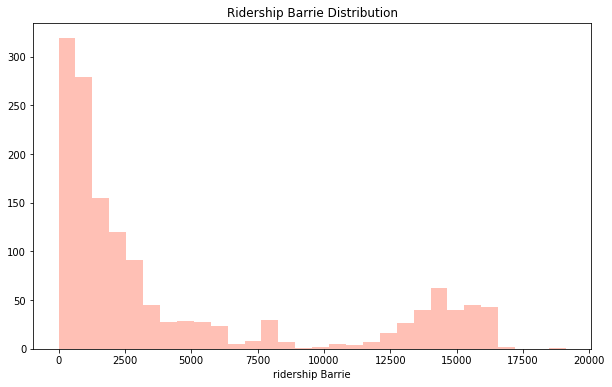

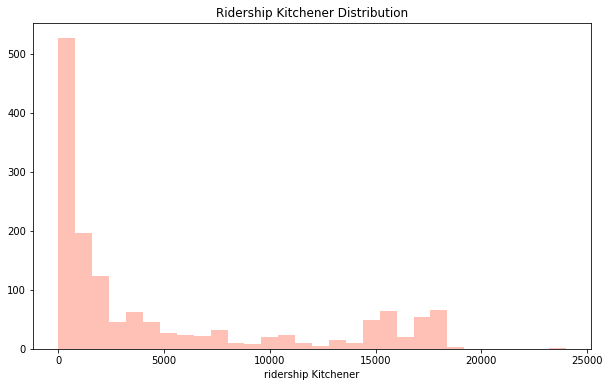

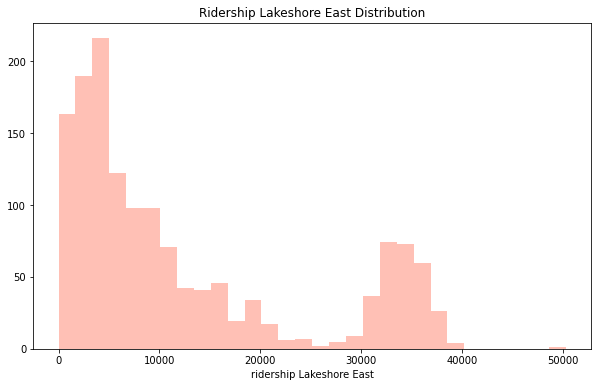

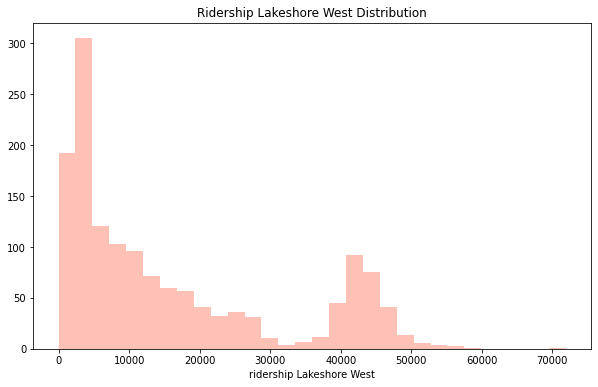

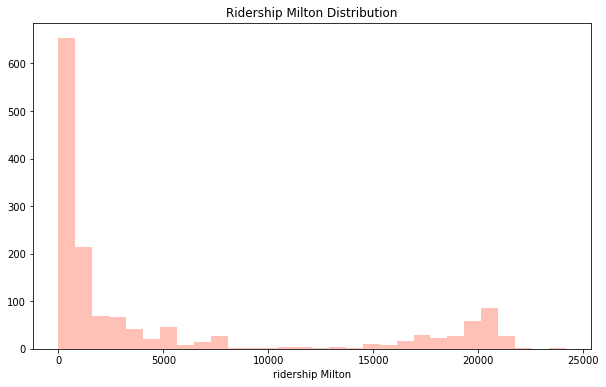

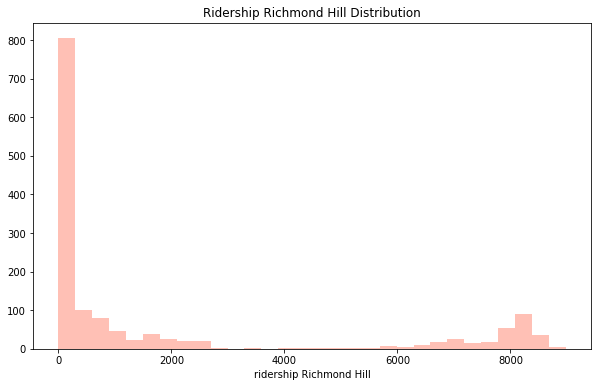

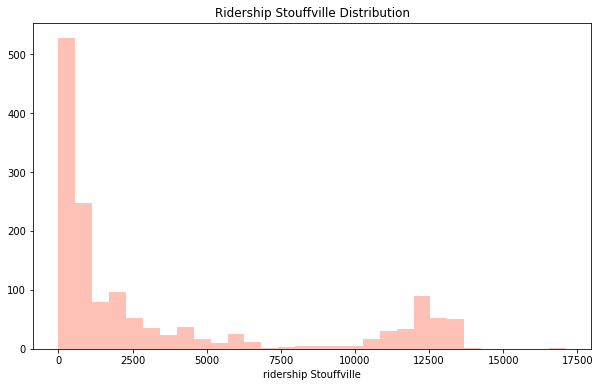

In [23]:
for st in stations:
    data = rc_df[f'ridership {st}']
    plt.figure(figsize=(10, 6))
    sns.distplot(data, kde=False, bins=30, color = 'tomato')
    plt.title(f'Ridership {st} Distribution')
    plt.show()

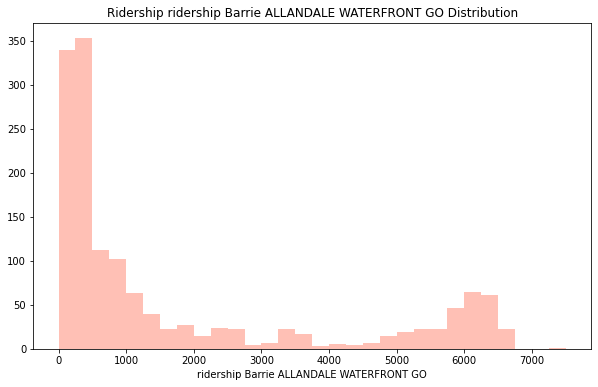

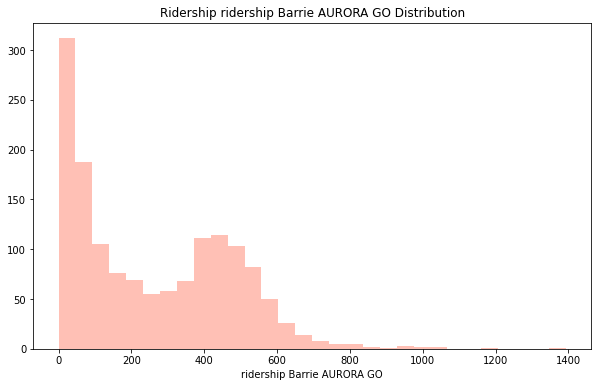

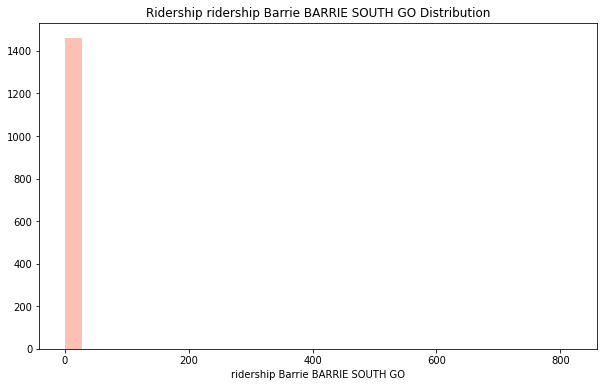

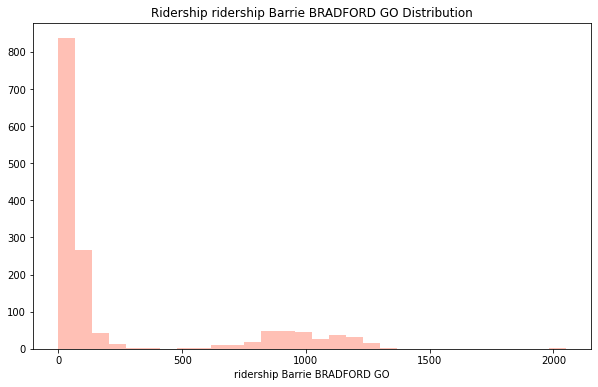

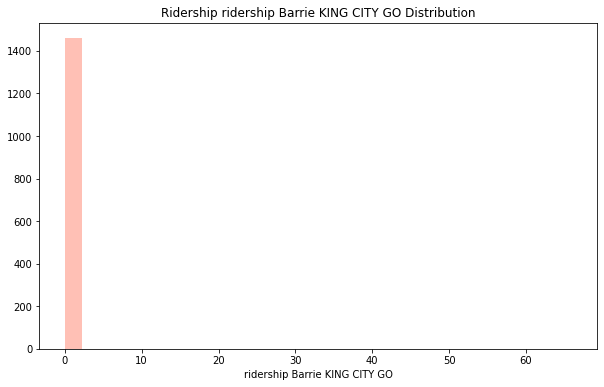

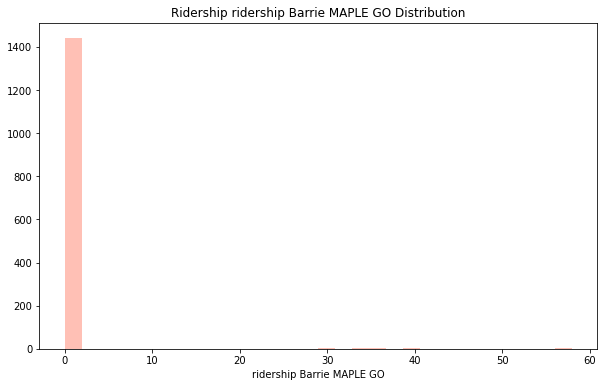

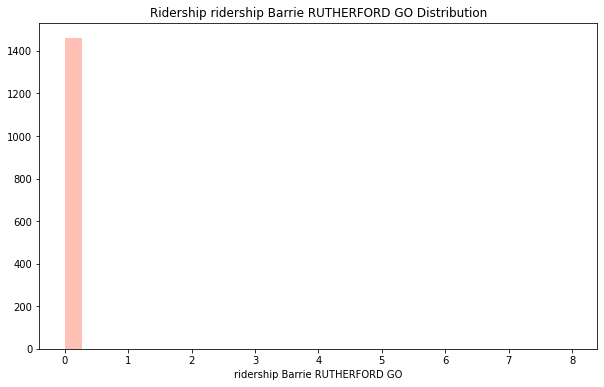

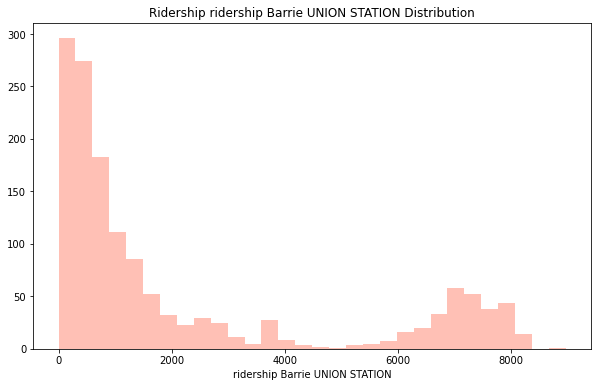

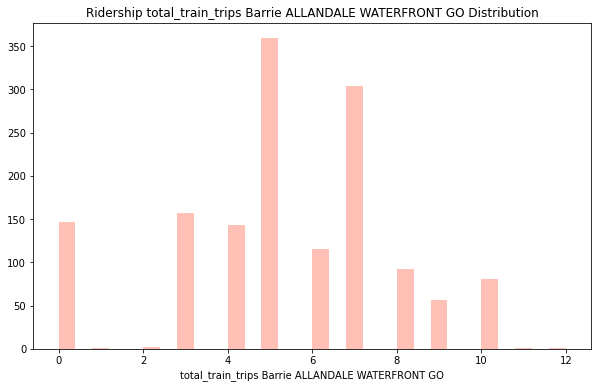

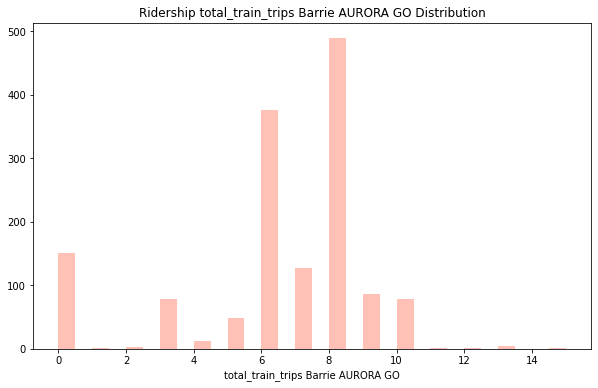

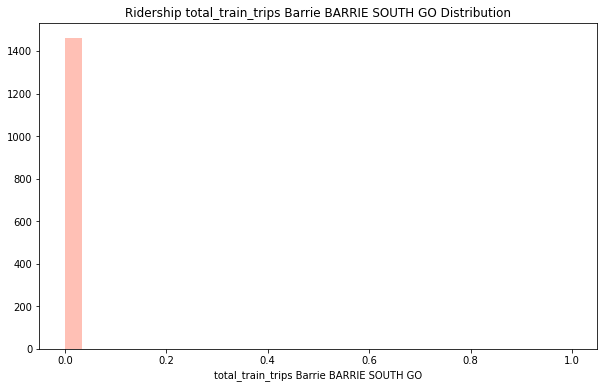

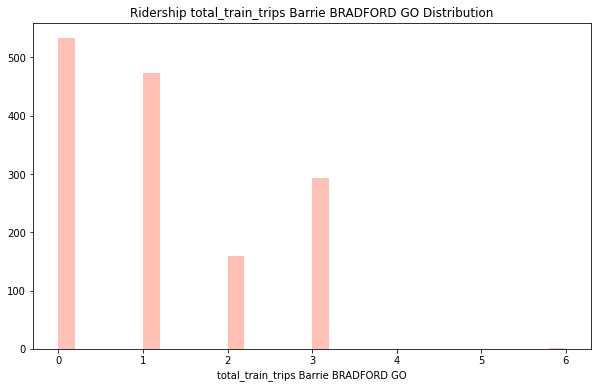

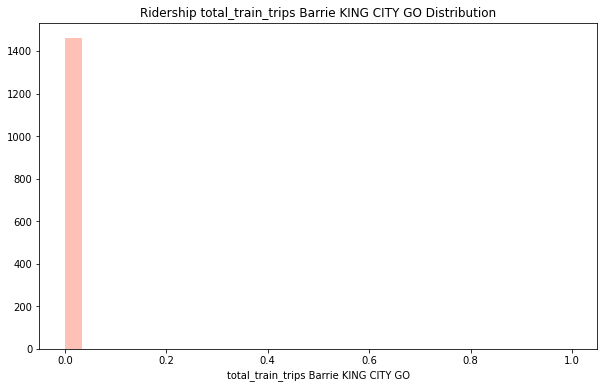

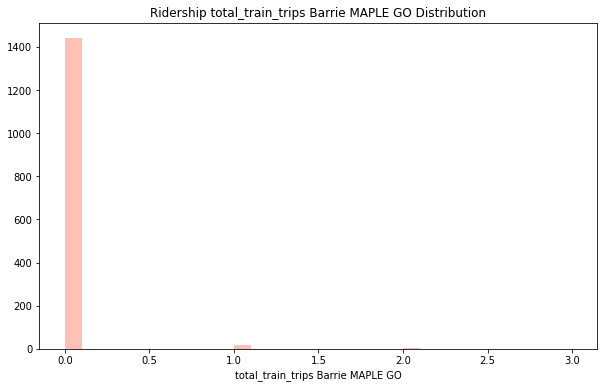

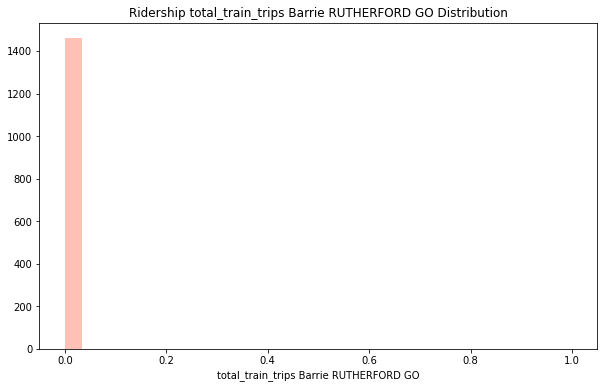

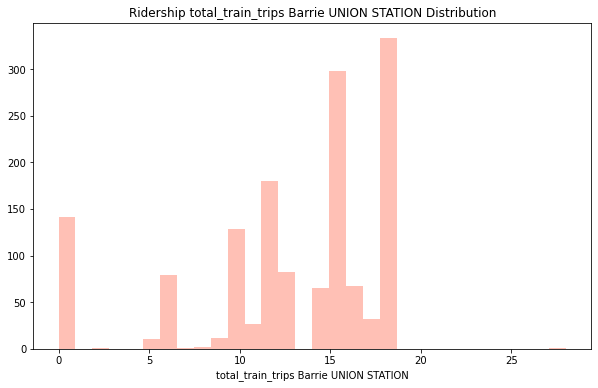

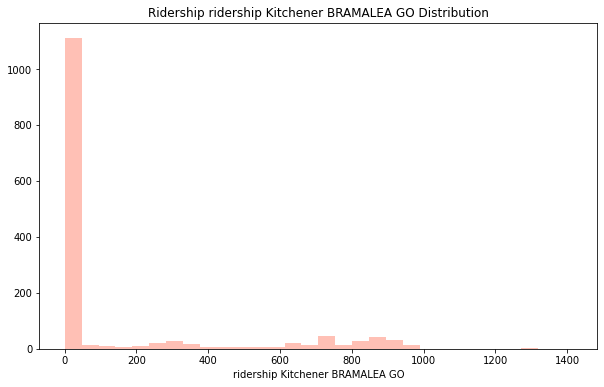

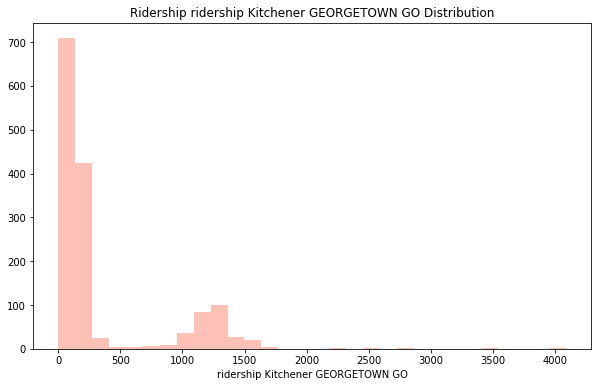

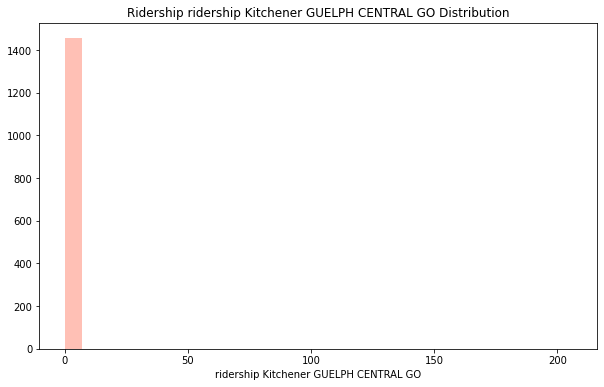

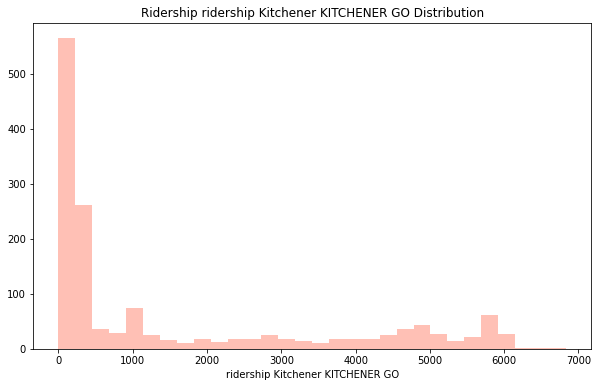

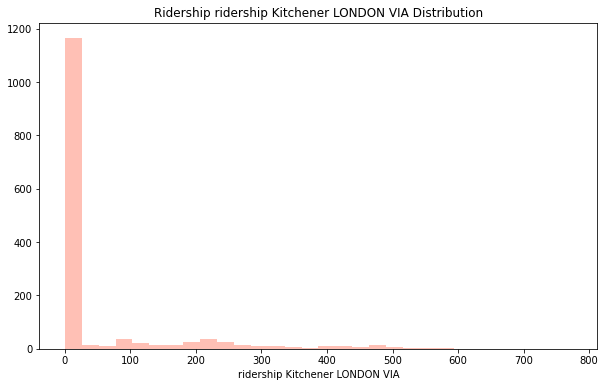

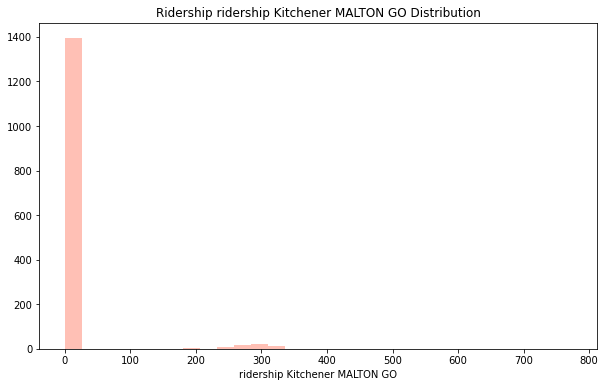

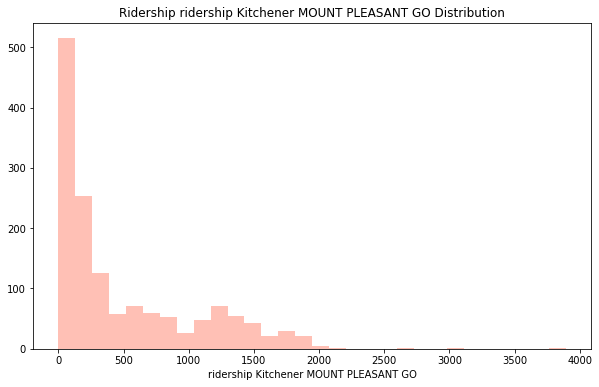

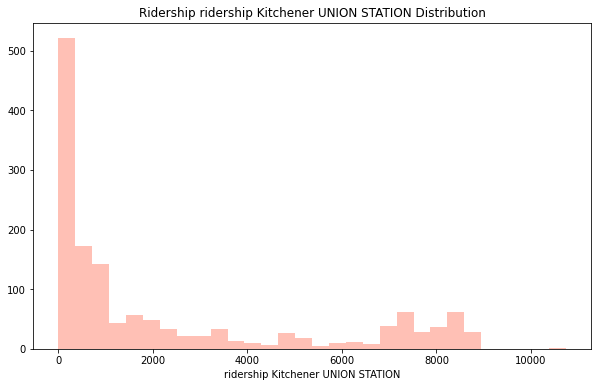

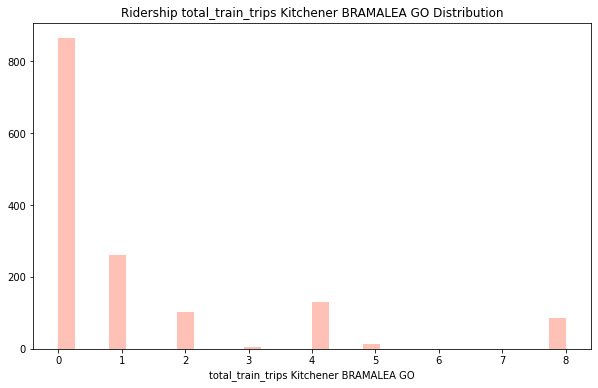

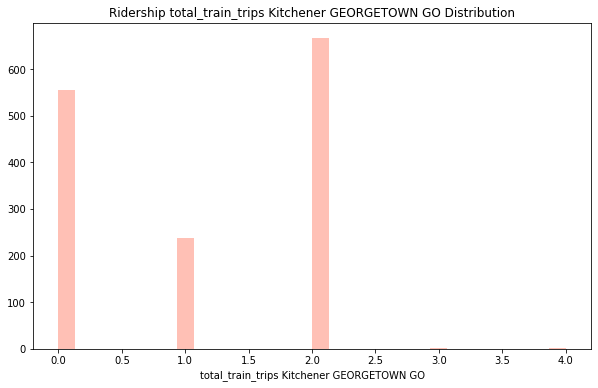

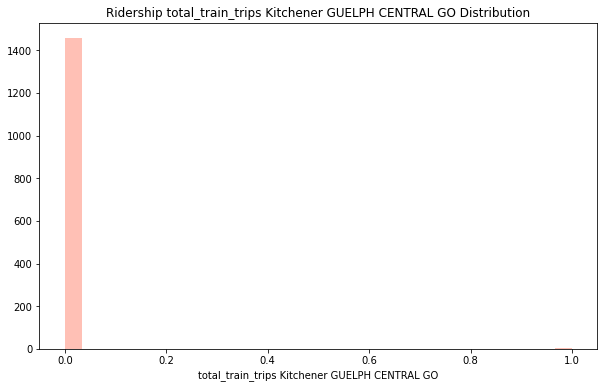

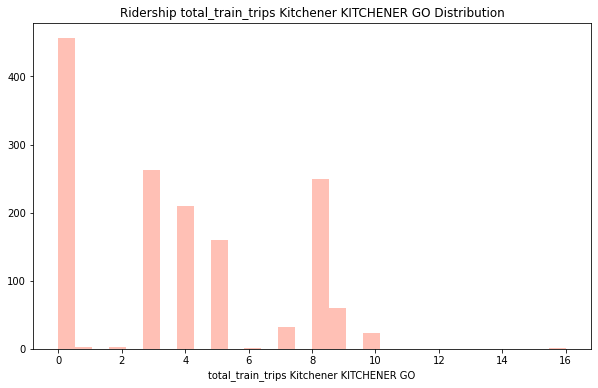

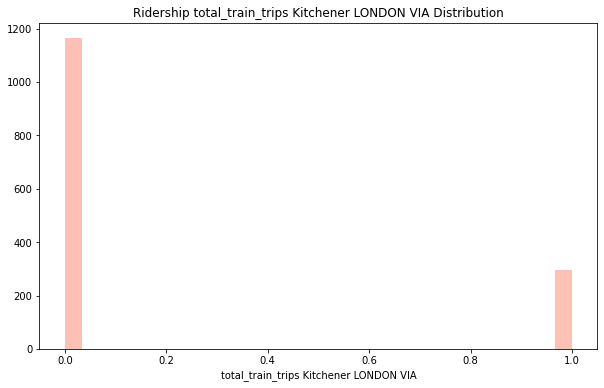

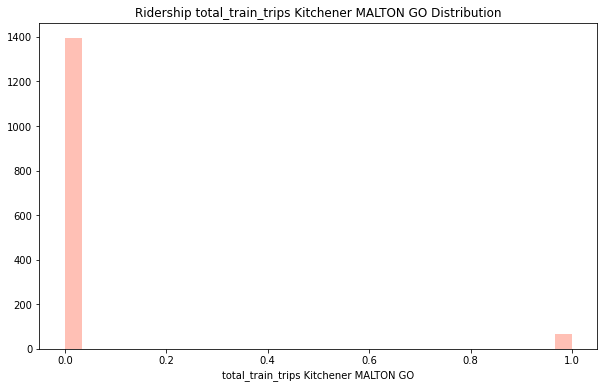

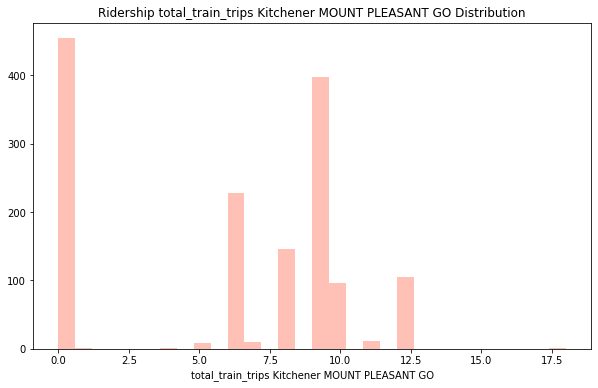

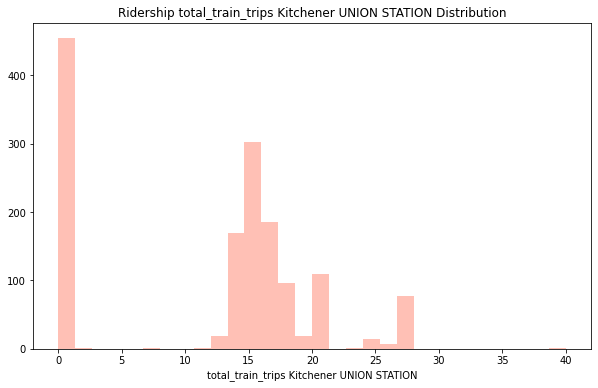

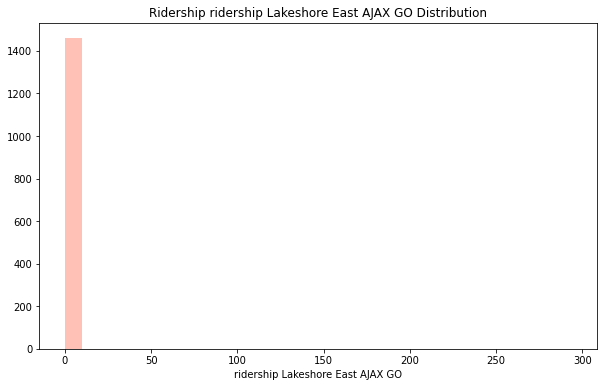

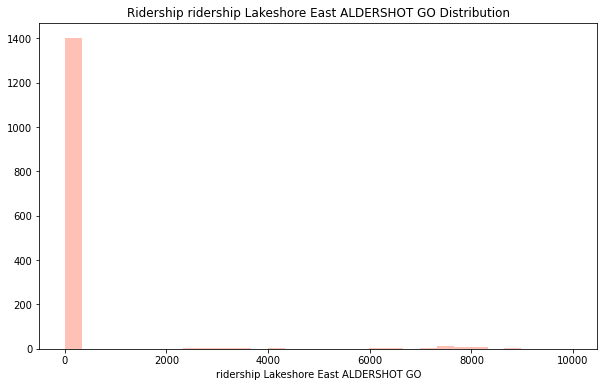

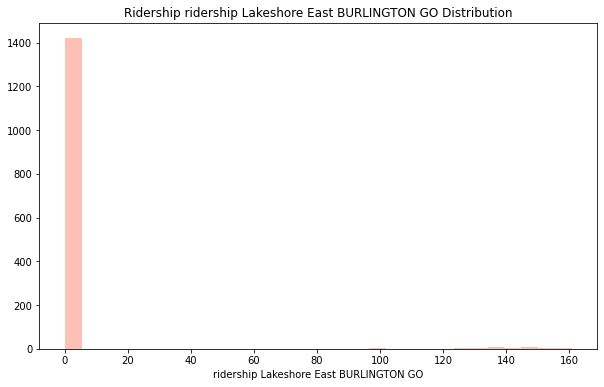

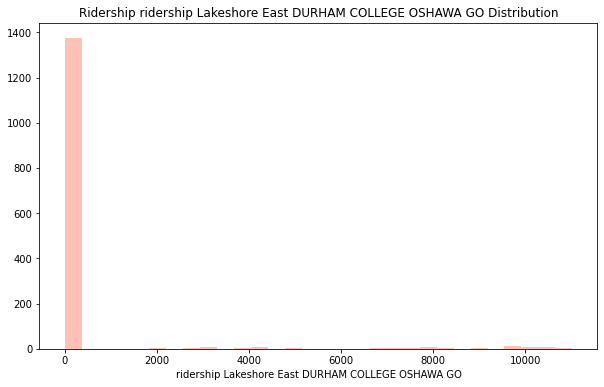

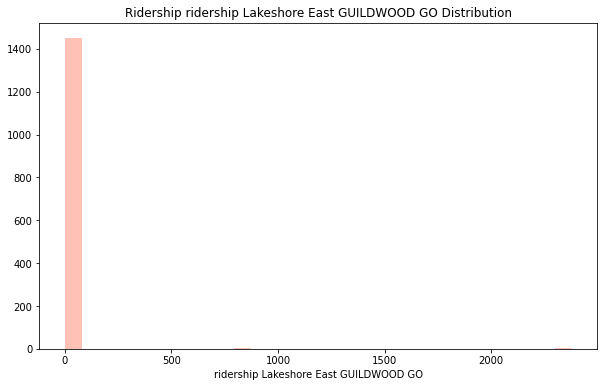

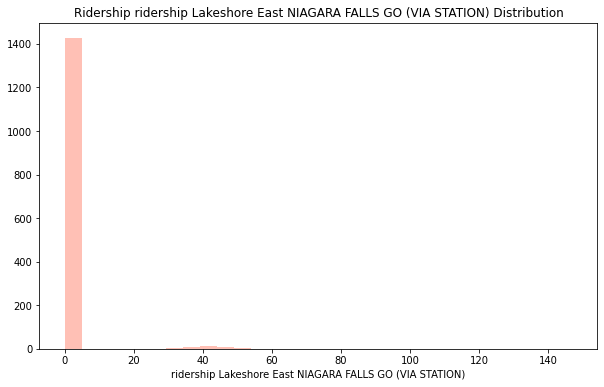

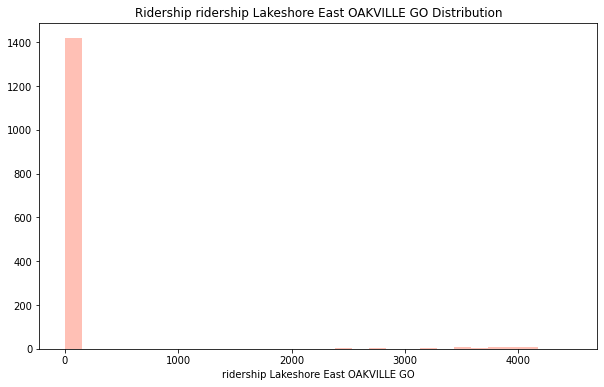

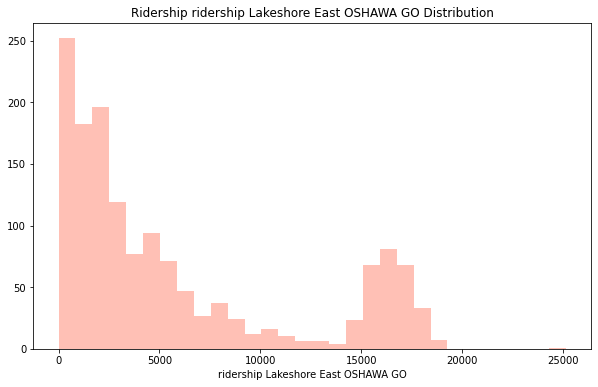

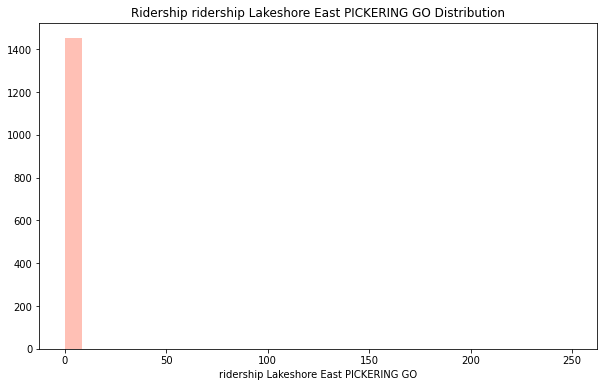

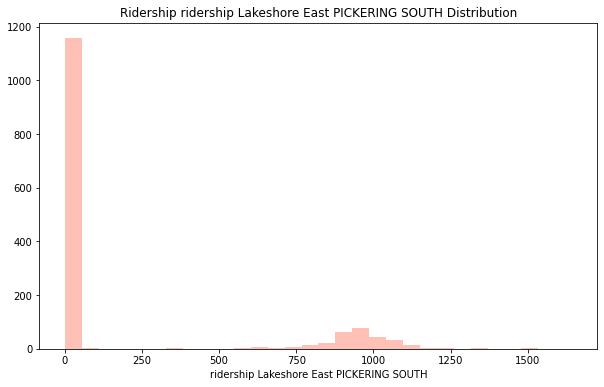

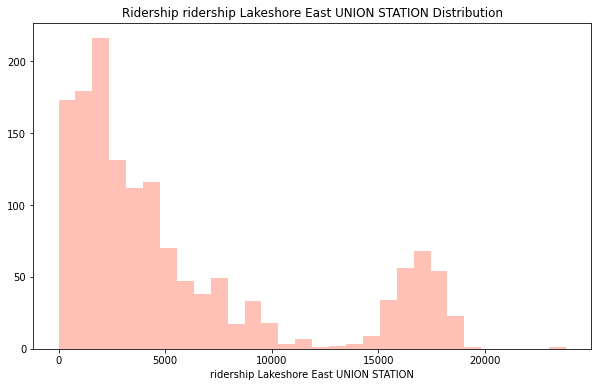

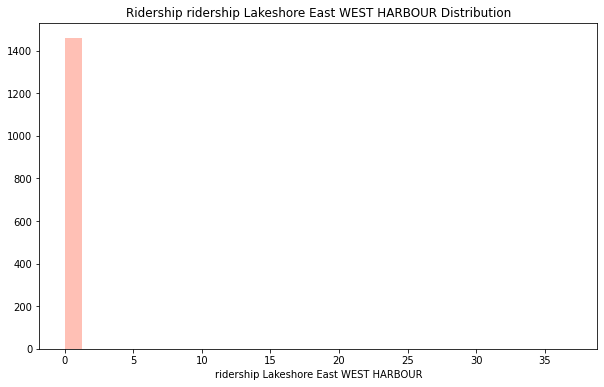

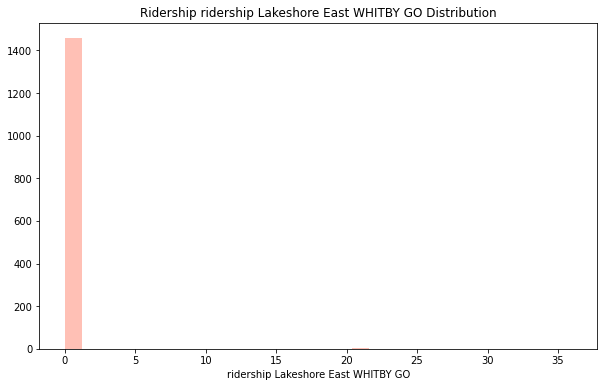

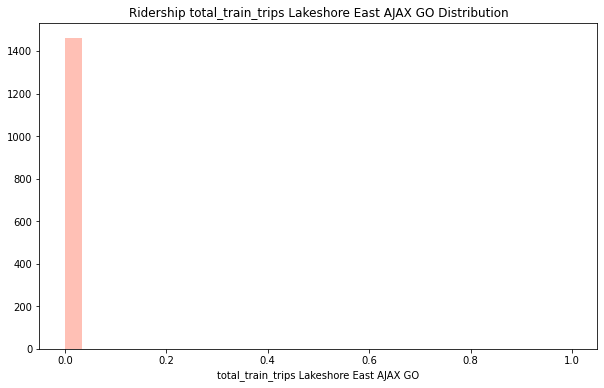

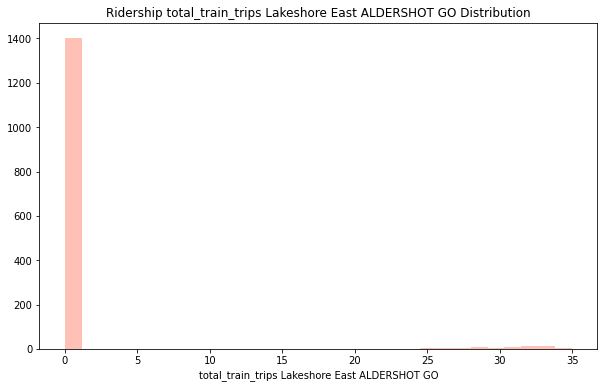

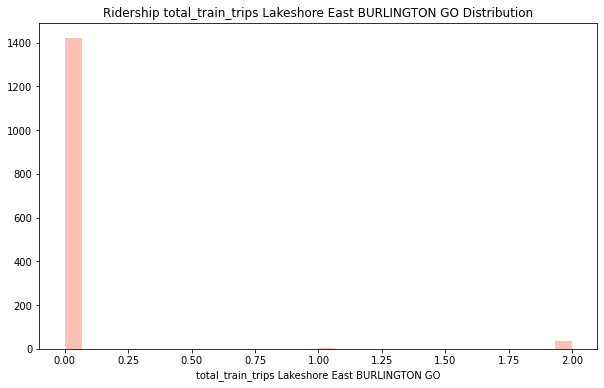

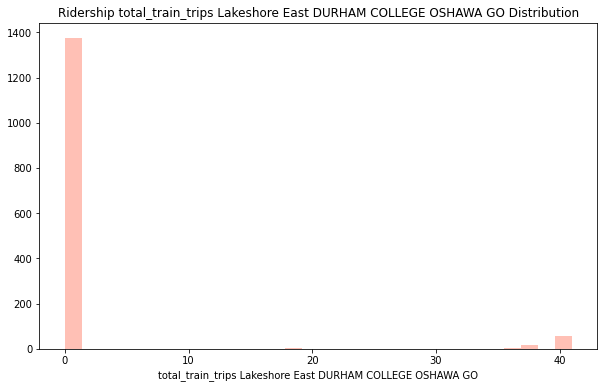

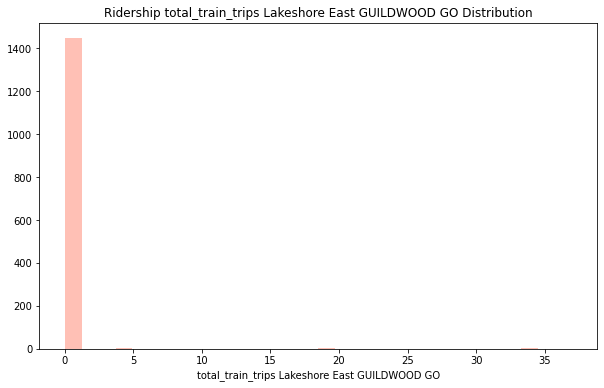

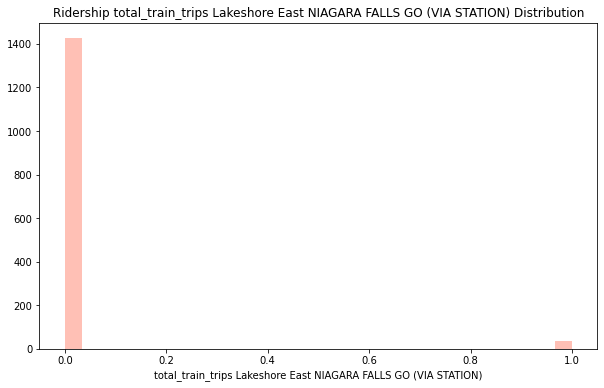

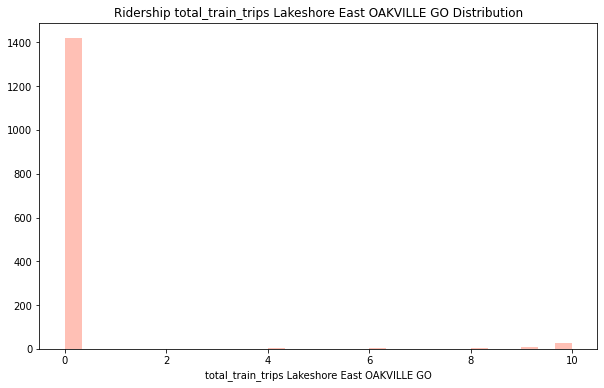

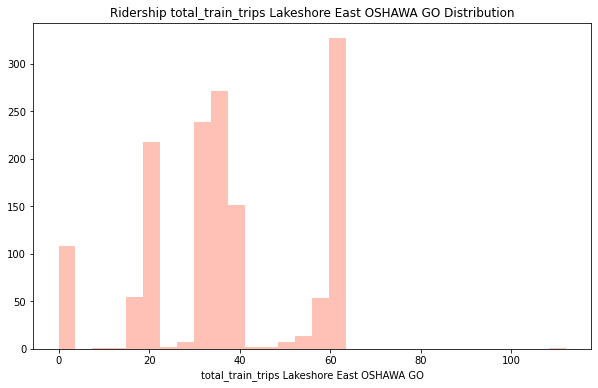

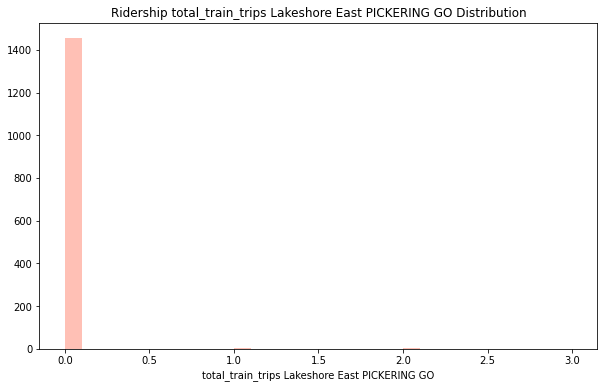

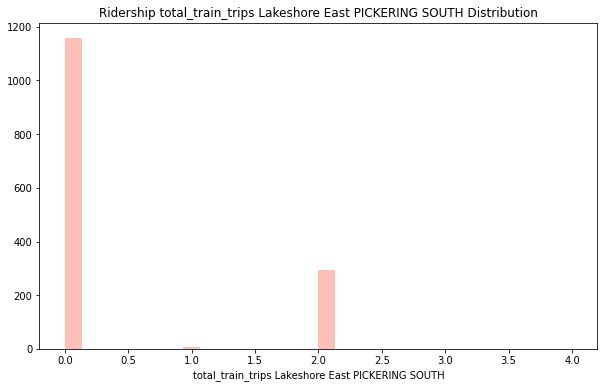

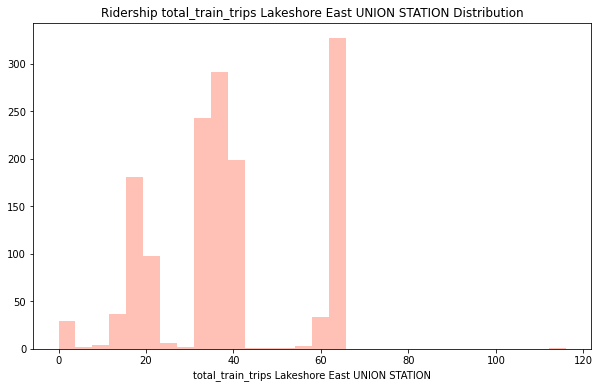

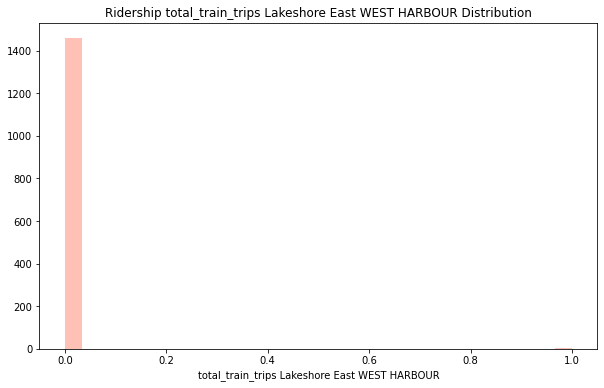

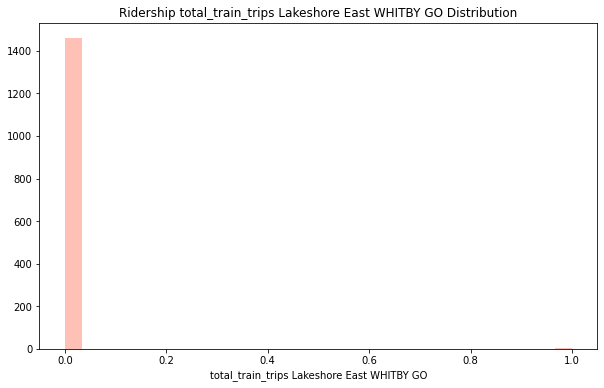

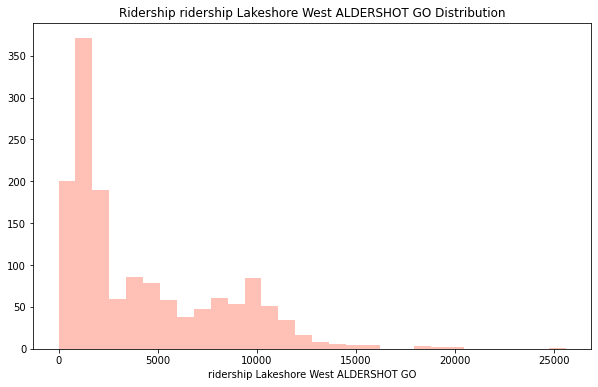

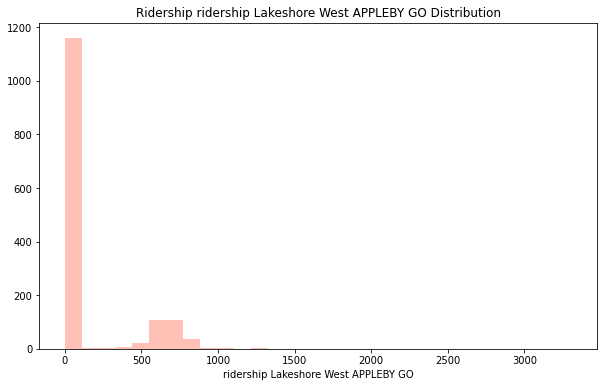

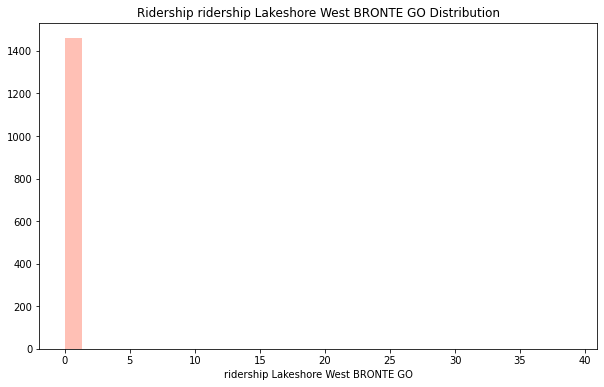

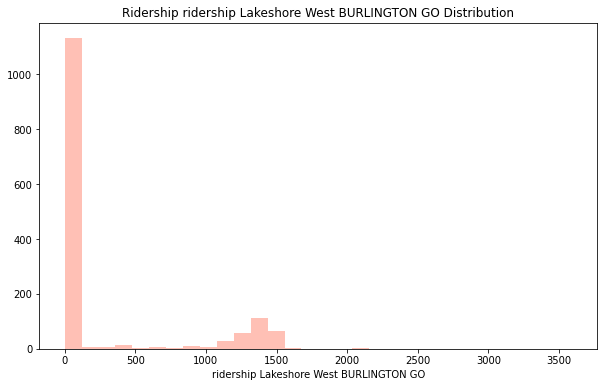

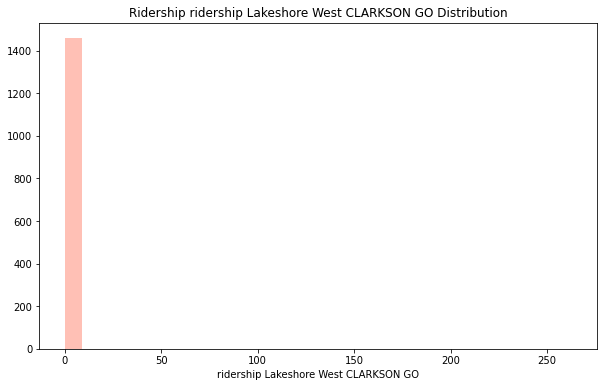

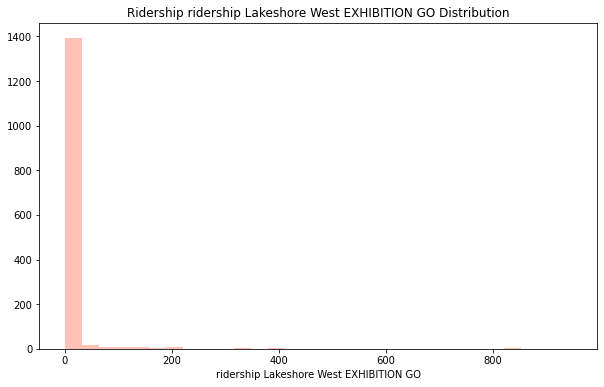

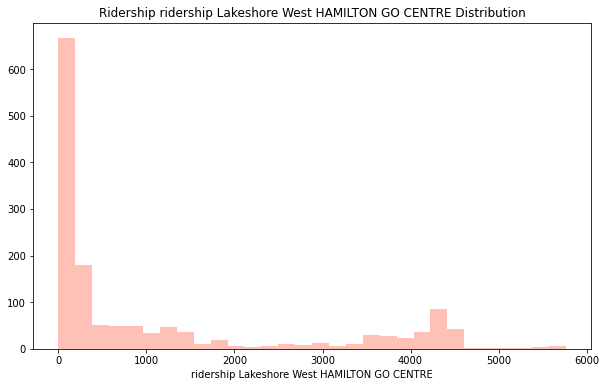

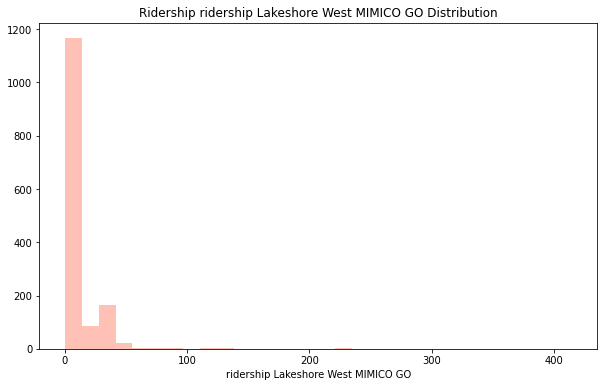

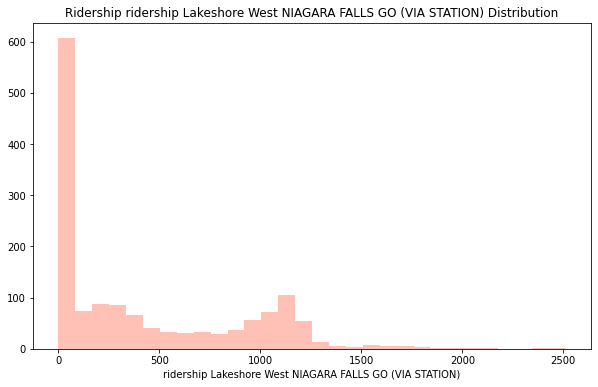

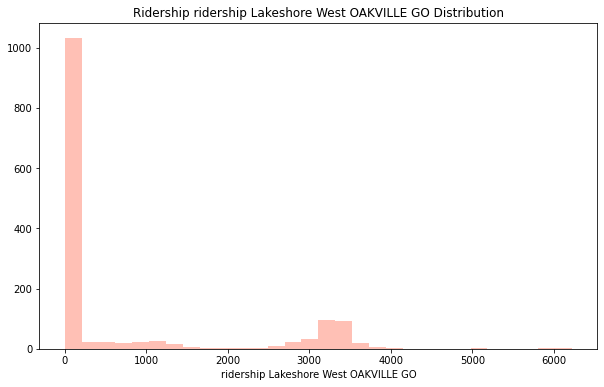

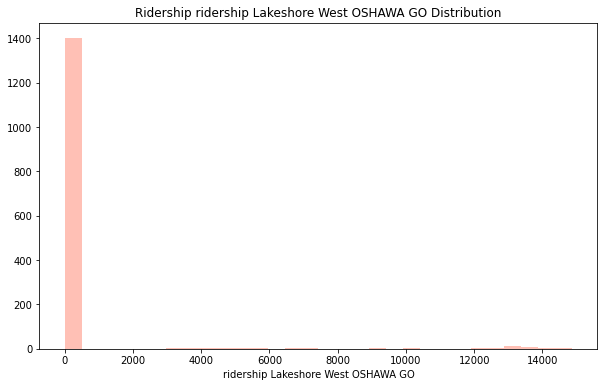

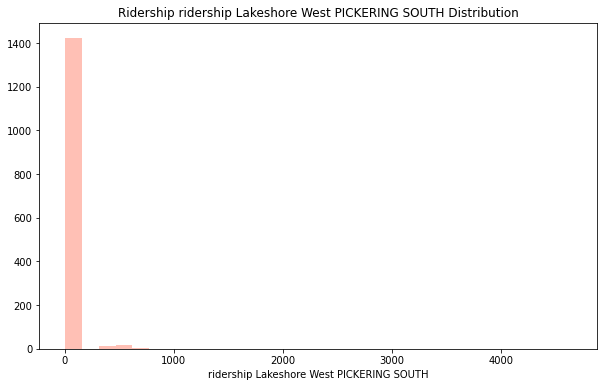

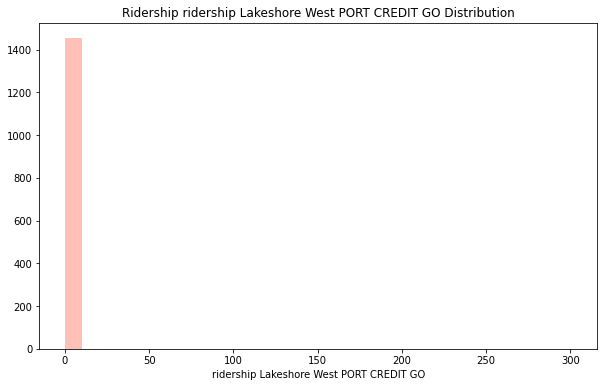

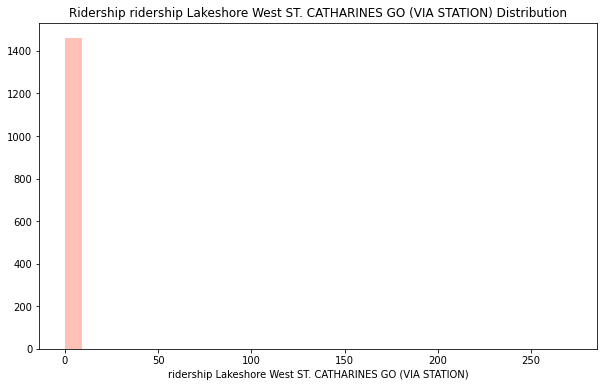

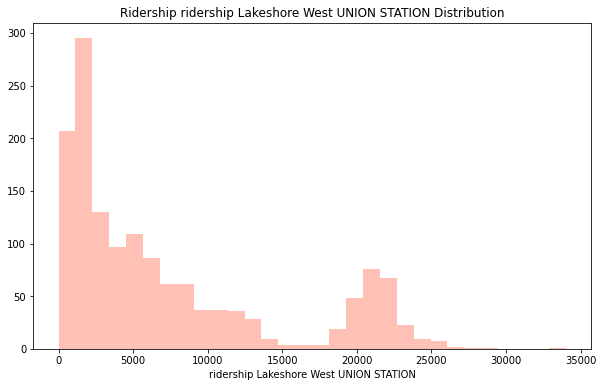

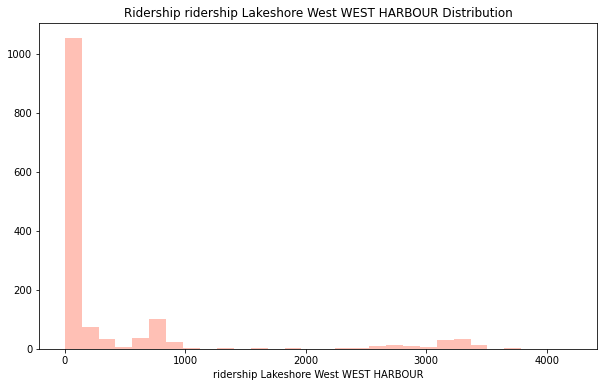

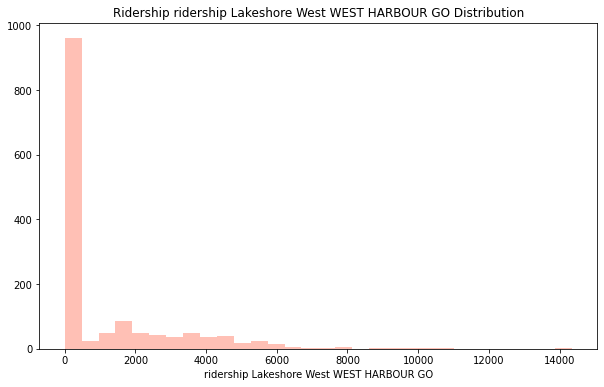

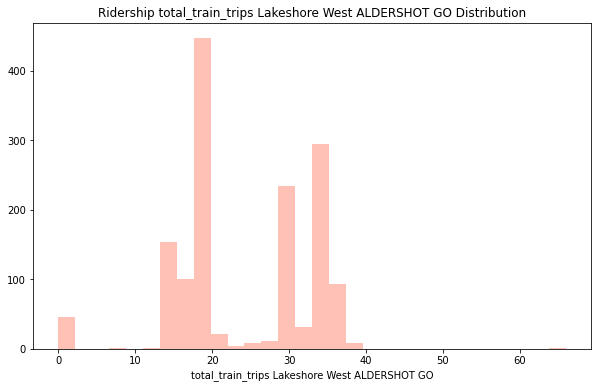

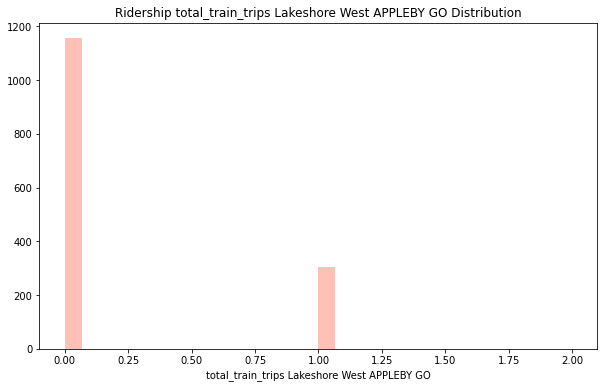

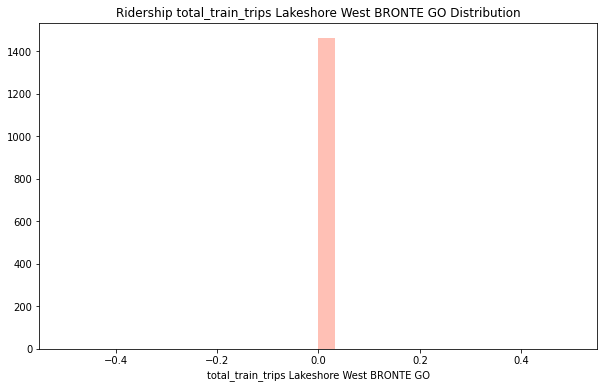

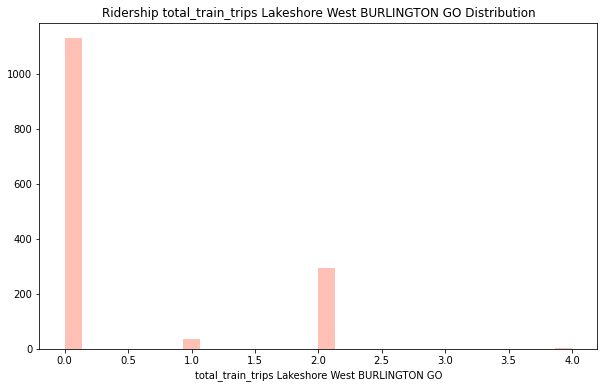

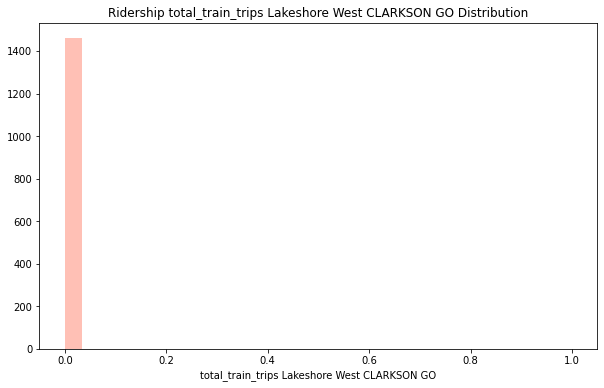

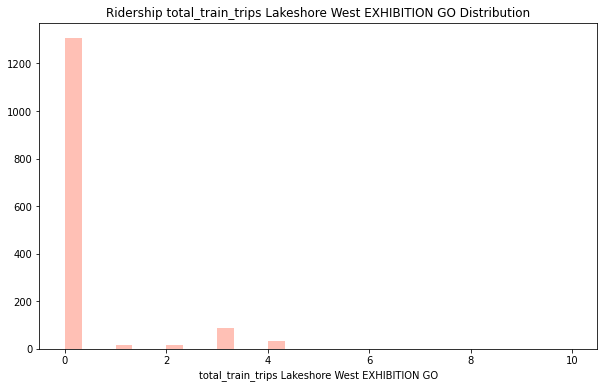

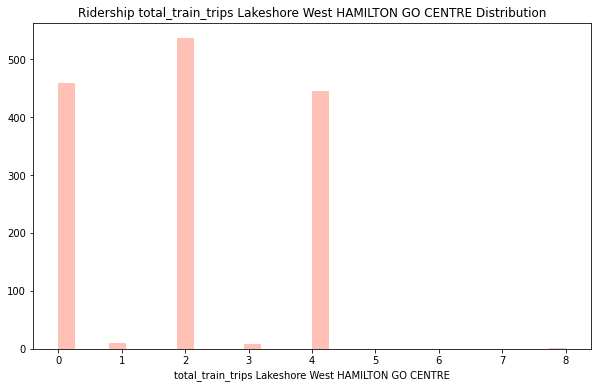

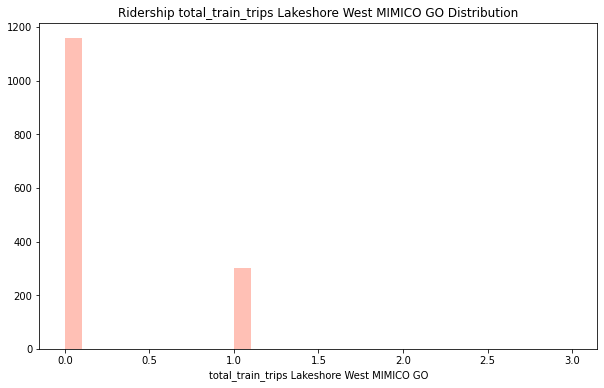

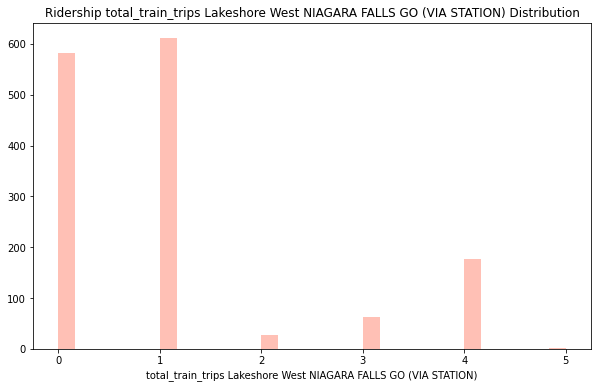

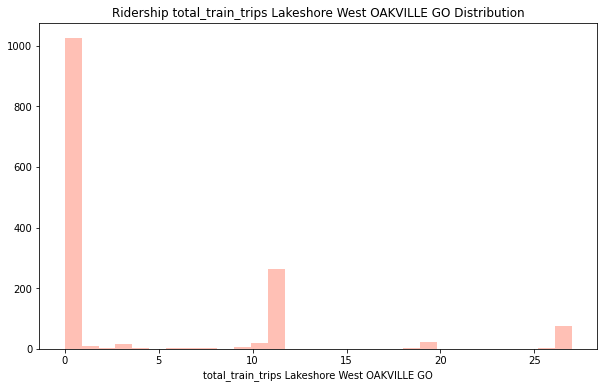

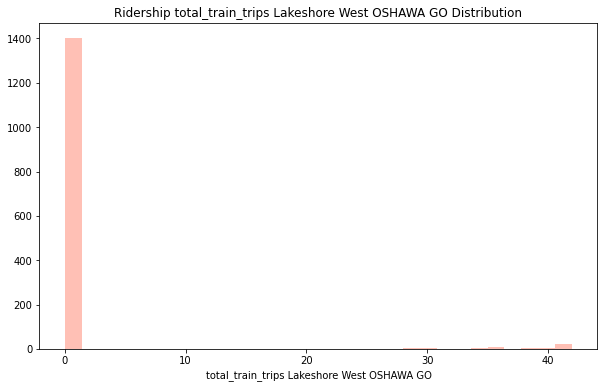

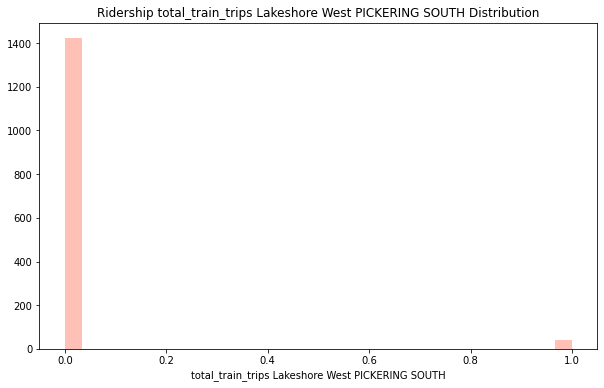

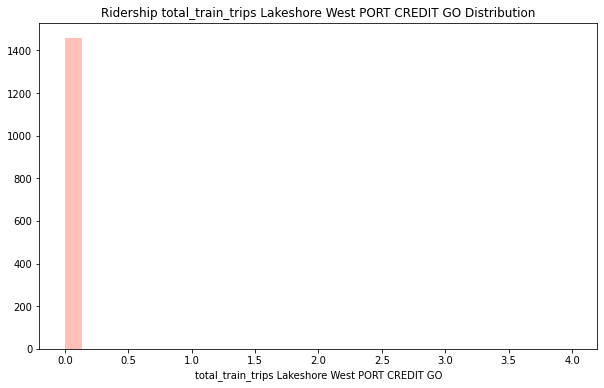

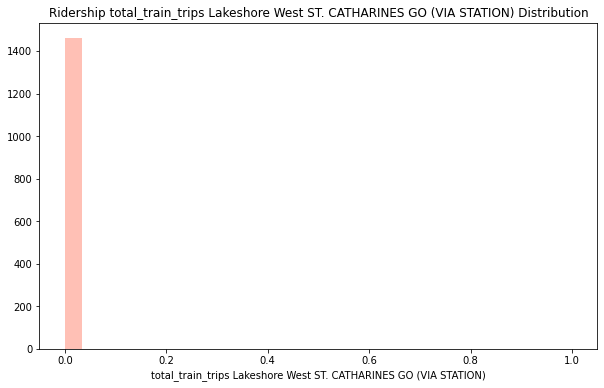

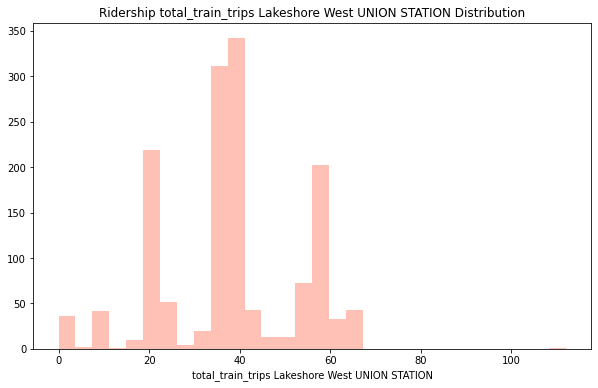

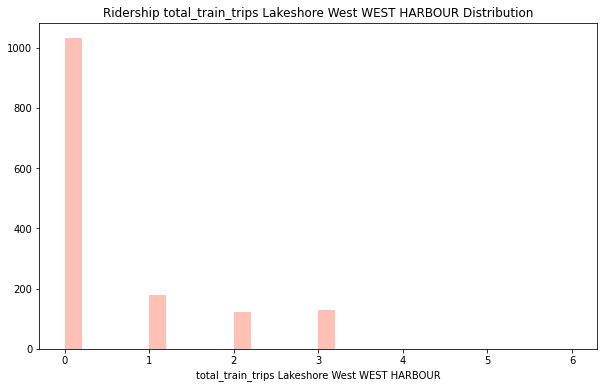

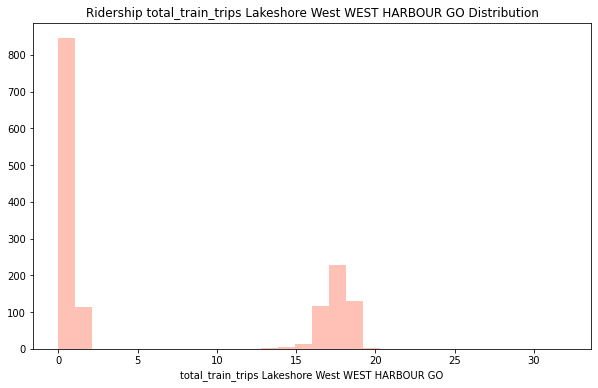

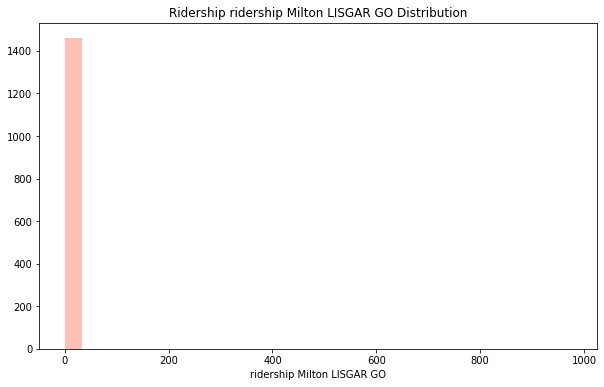

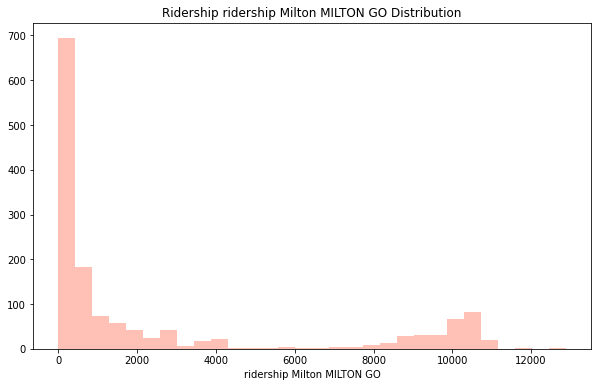

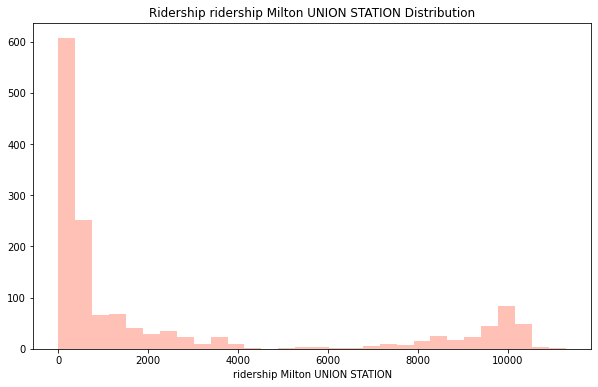

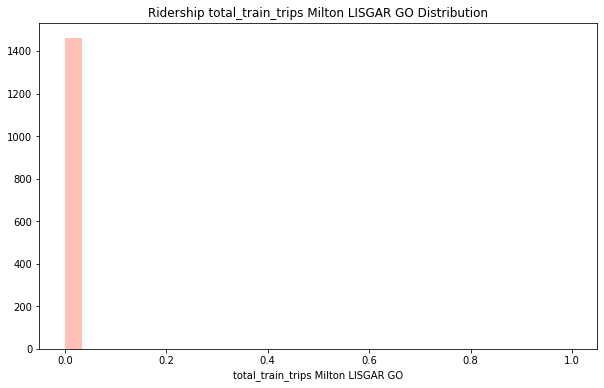

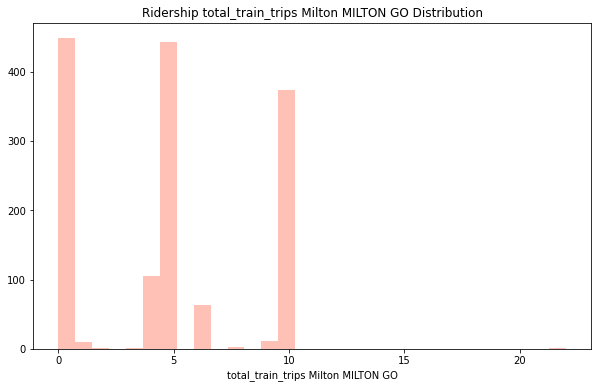

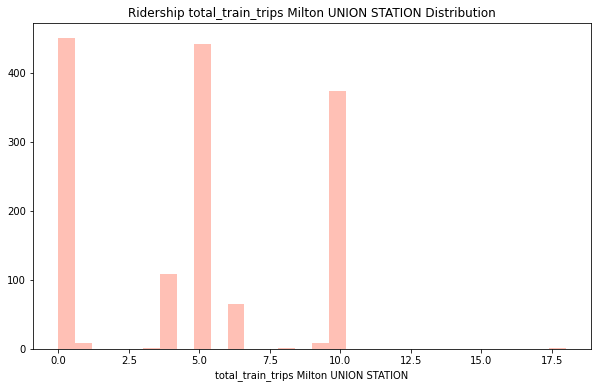

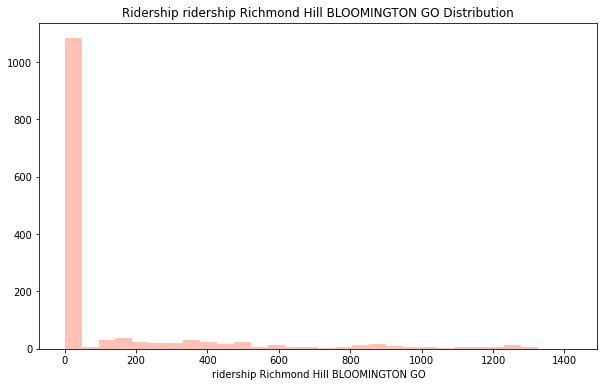

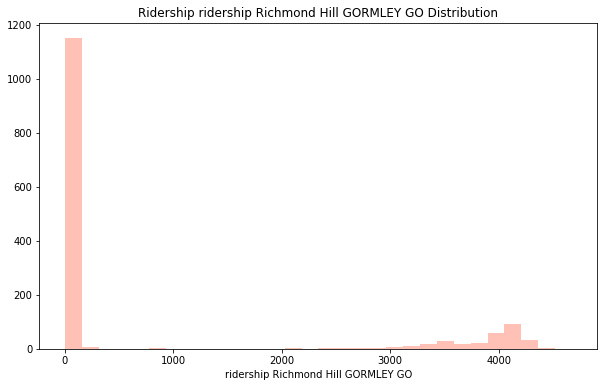

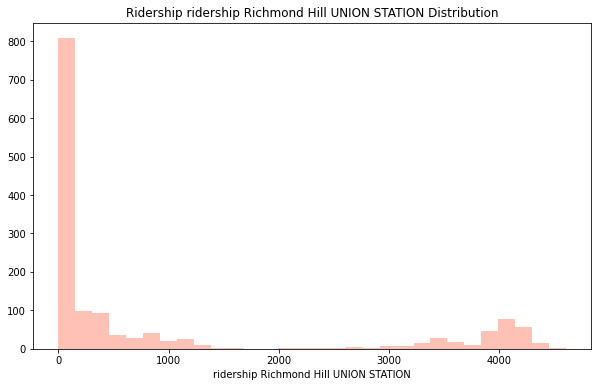

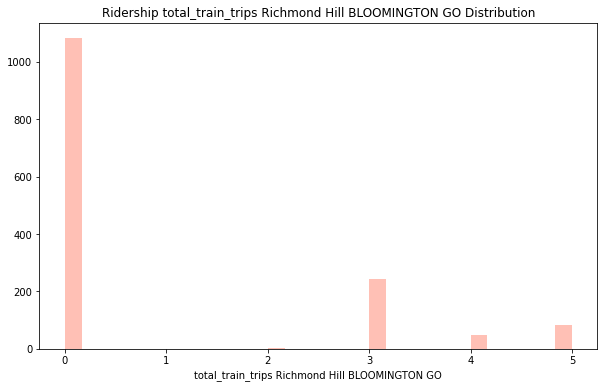

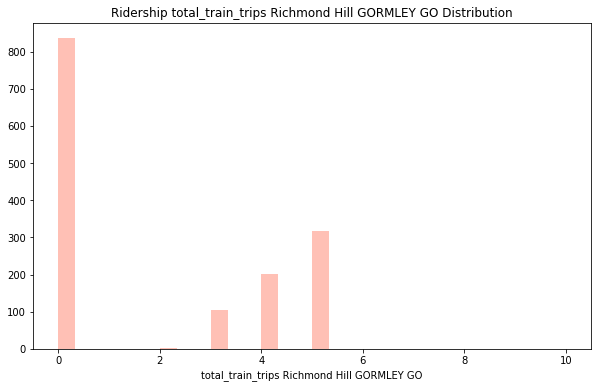

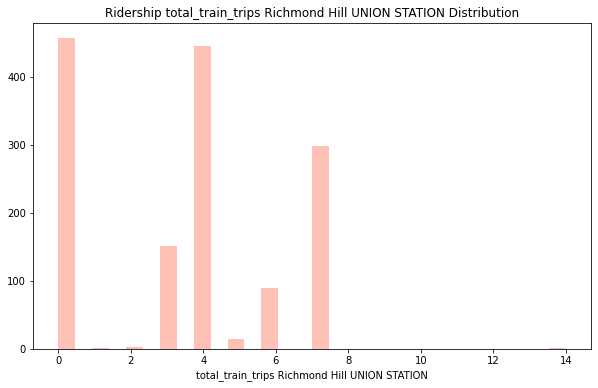

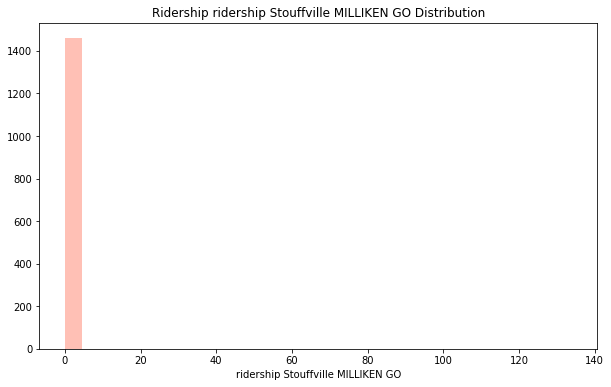

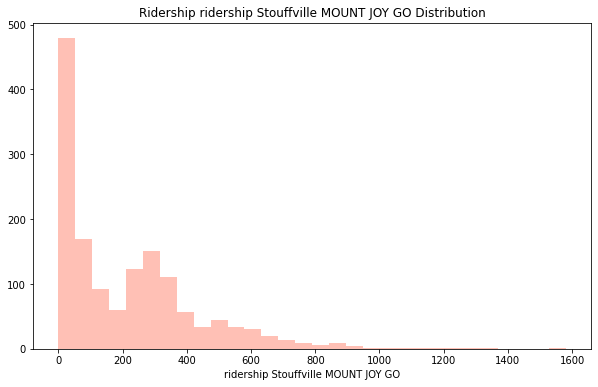

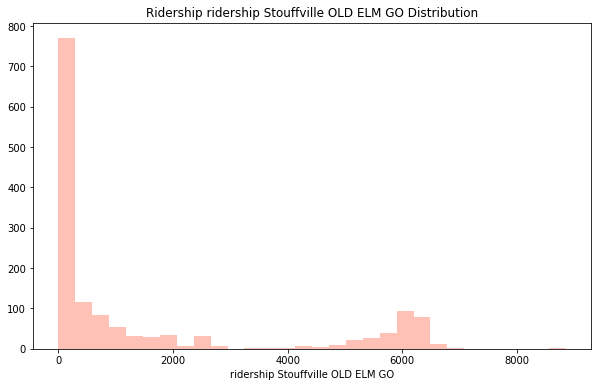

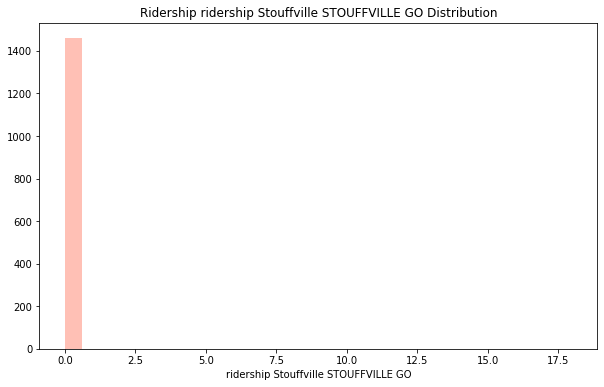

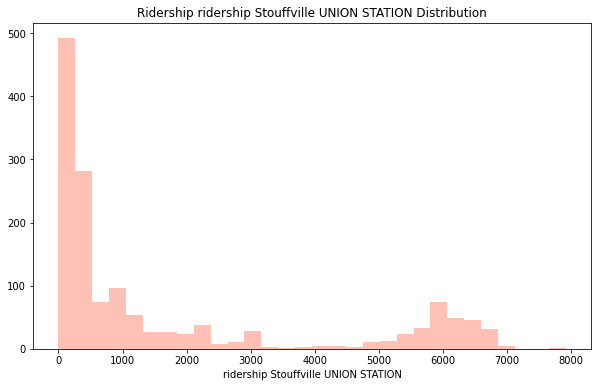

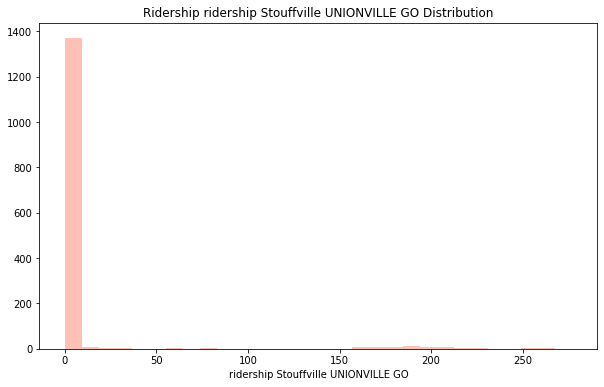

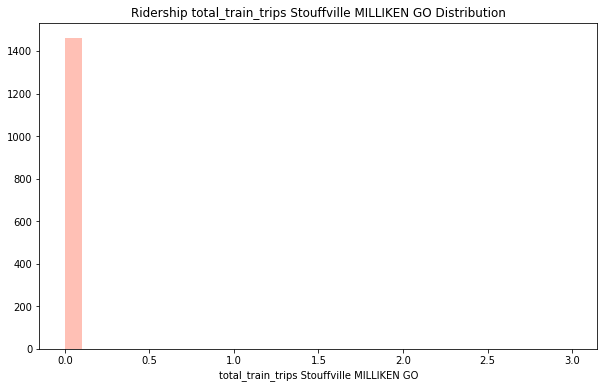

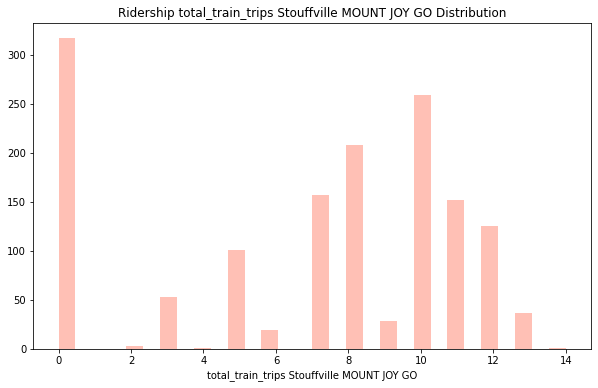

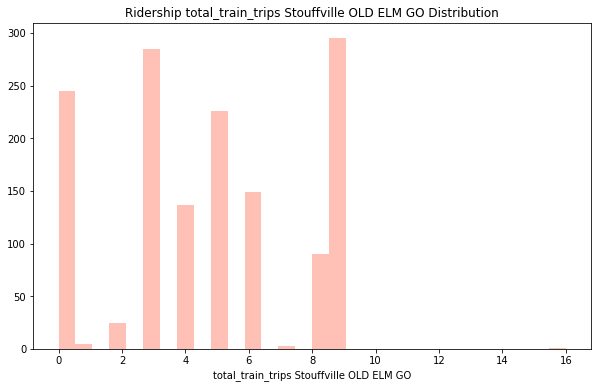

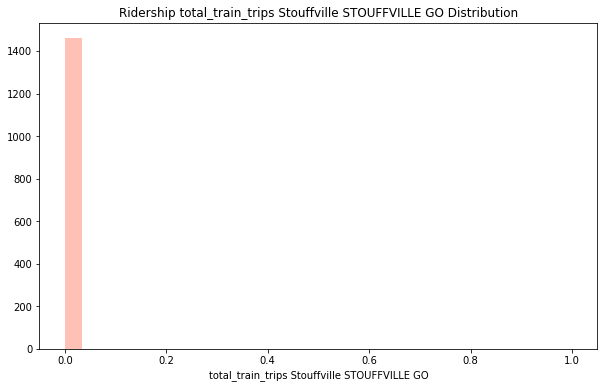

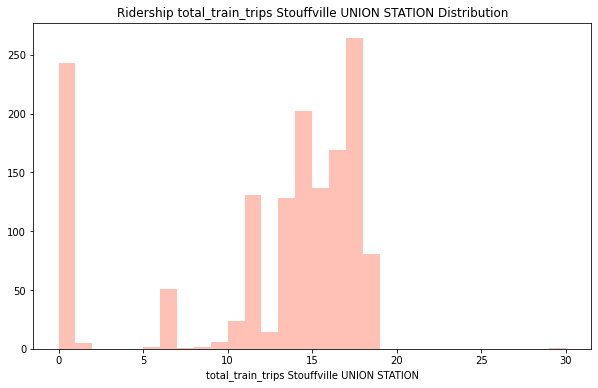

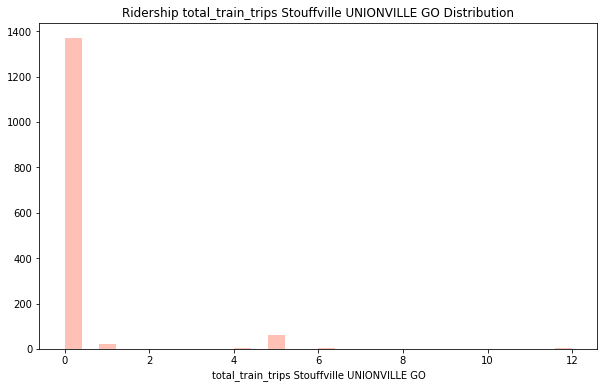

In [24]:
for st in stations:
    st_temp =  st_df.columns[st_df.columns.str.contains(pat = f'{st}')]
    for st_num in st_temp:
        data = st_df[f'{st_num}']

        plt.figure(figsize=(10, 6))
        sns.distplot(data, kde=False, bins=30, color = 'tomato')
        plt.title(f'Ridership {st_num} Distribution')
        plt.show()

### Regression Analysis

In [27]:
df = rc_df.iloc[:,1:] # reomove date column
df.head()

ridership Barrie  ridership Kitchener  ridership Lakeshore East  \
0            1149.0                  0.0                    5408.0   
1           10297.0              12586.0                   25057.0   
2           11395.0              13476.0                   27819.0   
3            9762.0              11701.0                   25222.0   
4            1549.0                  0.0                    7751.0   

   ridership Lakeshore West  ridership Milton  ridership Richmond Hill  \
0                    7056.0               0.0                      0.0   
1                   29978.0           14600.0                   5940.0   
2                   34463.0           15327.0                   6139.0   
3                   30343.0           13328.0                   5396.0   
4                   11118.0               0.0                      0.0   

   ridership Stouffville  total_train_trips Barrie  \
0                    0.0                      25.0   
1                 9087.0                      36.0   
2                 9671.0                      36.0   
3                 8636.0                      36.0   
4                    0.0                      25.0   

   total_train_trips Kitchener  total_train_trips Lakeshore East  \
0                          0.0                              72.0   
1                         31.0                             118.0   
2                         31.0                             119.0   
3                         31.0                             112.0   
4                          0.0                              69.0   

   total_train_trips Lakeshore West  total_train_trips Milton  \
0                              72.0                       0.0   
1                             107.0                      20.0   
2                             108.0                      20.0   
3                             102.0                      20.0   
4                              69.0                       0.0   

   total_train_trips Richmond Hill  total_train_trips Stouffville  Week  \
0                              0.0                            0.0     1   
1                             12.0                           29.0     1   
2                             12.0                           30.0     1   
3                             12.0                           30.0     1   
4                              0.0                            0.0     1   

   Month  Year  
0      1  2019  
1      1  2019  
2      1  2019  
3      1  2019  
4      1  2019

In [29]:
# train-test 75-25 split
df_train, df_test = train_test_split(df, 
                                     train_size = 0.75, 
                                     test_size = 0.25, 
                                     random_state = 100)

# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
numeric_vars = df.columns
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train[numeric_vars].head()

# apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
df_test[numeric_vars].head()

<IPython.core.display.Javascript object>

ridership Barrie  ridership Kitchener  ridership Lakeshore East  \
1437          0.448967             0.556708                  0.505077   
57            0.858954             0.866591                  0.815689   
780           0.045230             0.061652                  0.085382   
382           0.134857             0.000000                  0.253133   
1170          0.201214             0.237478                  0.261869   

      ridership Lakeshore West  ridership Milton  ridership Richmond Hill  \
1437                  0.512551          0.336072                 0.263194   
57                    0.710300          0.798310                 0.861950   
780                   0.062775          0.034350                 0.020973   
382                   0.291998          0.000000                 0.000000   
1170                  0.236503          0.127605                 0.085158   

      ridership Stouffville  total_train_trips Barrie  \
1437               0.436526                  0.888889   
57                 0.885164                  1.000000   
780                0.033085                  0.583333   
382                0.079536                  0.694444   
1170               0.190828                  0.722222   

      total_train_trips Kitchener  total_train_trips Lakeshore East  \
1437                     0.867925                          0.635659   
57                       0.584906                          0.604651   
780                      0.528302                          0.511628   
382                      0.000000                          0.542636   
1170                     0.566038                          0.550388   

      total_train_trips Lakeshore West  total_train_trips Milton  \
1437                          0.666667                       0.6   
57                            0.577778                       1.0   
780                           0.503704                       0.5   
382                           0.555556                       0.0   
1170                          0.511111                       0.5   

      total_train_trips Richmond Hill  total_train_trips Stouffville  \
1437                         0.583333                       0.916667   
57                           1.000000                       0.777778   
780                          0.666667                       0.500000   
382                          0.000000                       0.777778   
1170                         0.583333                       0.722222   

          Week     Month      Year  
1437  0.923077  1.000000  1.000000  
57    0.153846  0.090909  0.000000  
780   0.115385  0.090909  0.666667  
382   0.038462  0.000000  0.333333  
1170  0.192308  0.181818  1.000000

In [30]:
df_train.columns

Index(['ridership Barrie', 'ridership Kitchener', 'ridership Lakeshore East',
       'ridership Lakeshore West', 'ridership Milton',
       'ridership Richmond Hill', 'ridership Stouffville',
       'total_train_trips Barrie', 'total_train_trips Kitchener',
       'total_train_trips Lakeshore East', 'total_train_trips Lakeshore West',
       'total_train_trips Milton', 'total_train_trips Richmond Hill',
       'total_train_trips Stouffville', 'Week', 'Month', 'Year'],
      dtype='object')

In [32]:
for st in stations:
    print("---------------------------------------------------------")
    print(st)

    X_train = df_train[f'ridership {st}']
    y_train = df_train.drop(columns = [f'ridership {st}'])
    X_train = X_train.values.reshape(-1,1)
    
    X_test = df_test[f'ridership {st}']
    y_test = df_test.drop(columns = [f'ridership {st}'])
    X_test = X_test.values.reshape(-1,1)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    r_sq = model.score(X_train, y_train)
    print(f"coefficient of determination (R2) for ridership in {st}: {r_sq} \n")
    
    pred = model.predict(X_test)
#     print(sklearn.metrics.SCORERS.keys())
    print(f"ridership in {st} \n intercept: {model.intercept_} \n") #,  print(f"slope: {model.coef_}")


---------------------------------------------------------
Barrie
coefficient of determination (R2) for ridership in Barrie: 0.5456041019239153 

ridership in Barrie 
 intercept: [-0.00571456  0.05546336  0.05641107 -0.04451814 -0.06144351 -0.01752346
  0.36063978  0.20357201  0.26068896  0.29067713  0.12225861  0.15187642
  0.3347453   0.49601628  0.50685355  0.64636185] 

---------------------------------------------------------
Kitchener
coefficient of determination (R2) for ridership in Kitchener: 0.5499337177626018 

ridership in Kitchener 
 intercept: [ 0.01385063  0.06812625  0.07048068 -0.03208256 -0.04619181 -0.00632009
  0.36653798  0.19192189  0.26474366  0.29446895  0.118598    0.14629704
  0.32975037  0.49574668  0.50629264  0.62024474] 

---------------------------------------------------------
Lakeshore East
coefficient of determination (R2) for ridership in Lakeshore East: 0.5299003721402513 

ridership in Lakeshore East 
 intercept: [-0.05650392 -0.05533666  0.00278735 

# k-fold CV

In [34]:
for st in stations:
    print("---------------------------------------------------------")
    print(st)

    X_train = df_train[f'ridership {st}']
    y_train = df_train.drop(columns = [f'ridership {st}'])
    X_train = X_train.values.reshape(-1,1)
    
    X_test = df_test[f'ridership {st}']
    y_test = df_test.drop(columns = [f'ridership {st}'])
    X_test = X_test.values.reshape(-1,1)
    
    model = LinearRegression()

    r2 = cross_val_score(model, X_train,y_train,scoring='r2',cv=10)
    mean_r2 = np.mean(r2)
    print(f"coefficient of determination (R2) for ridership in {st}: {mean_r2} \n")


---------------------------------------------------------
Barrie
coefficient of determination (R2) for ridership in Barrie: 0.5407156018164897 

---------------------------------------------------------
Kitchener
coefficient of determination (R2) for ridership in Kitchener: 0.5446405643978762 

---------------------------------------------------------
Lakeshore East
coefficient of determination (R2) for ridership in Lakeshore East: 0.5243940620698606 

---------------------------------------------------------
Lakeshore West
coefficient of determination (R2) for ridership in Lakeshore West: 0.46989137157669536 

---------------------------------------------------------
Milton
coefficient of determination (R2) for ridership in Milton: 0.533566630998902 

---------------------------------------------------------
Richmond Hill
coefficient of determination (R2) for ridership in Richmond Hill: 0.5239958791982269 

---------------------------------------------------------
Stouffville
coeffici

# Ridge and Lasso Regression

In [40]:
for st in stations:
    print("---------------------------------------------------------")
    print(st)

    X_train = df_train[f'ridership {st}']
    y_train = df_train.drop(columns = [f'ridership {st}'])
    X_train = X_train.values.reshape(-1,1)
    
    X_test = df_test[f'ridership {st}']
    y_test = df_test.drop(columns = [f'ridership {st}'])
    X_test = X_test.values.reshape(-1,1)
    
    ridge = Ridge()
    parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,40,50,100]}
    ridge_reg = GridSearchCV(ridge, parameters, scoring='r2', cv=10)
    ridge_reg.fit(X_train,y_train)

    print(f"Best parameters for ridership in {st}: {ridge_reg.best_params_}")
    print(f"Best score for ridership in {st}: {ridge_reg.best_score_}")
    
    pred_ridge=ridge_reg.predict(X_test)

---------------------------------------------------------
Barrie
Best parameters for ridership in Barrie: {'alpha': 0.01}
Best score for ridership in Barrie: 0.540716007842814
---------------------------------------------------------
Kitchener
Best parameters for ridership in Kitchener: {'alpha': 0.01}
Best score for ridership in Kitchener: 0.5446411252243932
---------------------------------------------------------
Lakeshore East
Best parameters for ridership in Lakeshore East: {'alpha': 0.01}
Best score for ridership in Lakeshore East: 0.5243948064907303
---------------------------------------------------------
Lakeshore West
Best parameters for ridership in Lakeshore West: {'alpha': 0.01}
Best score for ridership in Lakeshore West: 0.46989244440754
---------------------------------------------------------
Milton
Best parameters for ridership in Milton: {'alpha': 0.01}
Best score for ridership in Milton: 0.5335669780217649
---------------------------------------------------------
Ric

In [39]:
for st in stations:
    print("---------------------------------------------------------")
    print(st)

    X_train = df_train[f'ridership {st}']
    y_train = df_train.drop(columns = [f'ridership {st}'])
    X_train = X_train.values.reshape(-1,1)
    
    X_test = df_test[f'ridership {st}']
    y_test = df_test.drop(columns = [f'ridership {st}'])
    X_test = X_test.values.reshape(-1,1)
    
    lasso=Lasso()
    parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,40,50,100]}
    lasso_reg=GridSearchCV(lasso,parameters,scoring='r2',cv=5)
    lasso_reg.fit(X_train,y_train)

    print(f"Best parameters for ridership in {st}: {lasso_reg.best_params_}")
    print(f"Best score for ridership in {st}: {lasso_reg.best_score_}")
    
    pred_lasso=lasso_reg.predict(X_test)


---------------------------------------------------------
Barrie
Best parameters for ridership in Barrie: {'alpha': 1e-08}
Best score for ridership in Barrie: 0.5420976438477974
---------------------------------------------------------
Kitchener
Best parameters for ridership in Kitchener: {'alpha': 1e-08}
Best score for ridership in Kitchener: 0.5465688818069757
---------------------------------------------------------
Lakeshore East
Best parameters for ridership in Lakeshore East: {'alpha': 1e-08}
Best score for ridership in Lakeshore East: 0.5261094743605513
---------------------------------------------------------
Lakeshore West
Best parameters for ridership in Lakeshore West: {'alpha': 1e-08}
Best score for ridership in Lakeshore West: 0.4721556113154387
---------------------------------------------------------
Milton
Best parameters for ridership in Milton: {'alpha': 1e-08}
Best score for ridership in Milton: 0.5352207769459096
-----------------------------------------------------